In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.GeNVI_method import GeNVariationalInference, GeNetEns

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
#from Experiments.foong import Setup
#setup=Setup(device, layerwidth=50)

from Experiments.boston import Setup
setup=Setup(device)

# Target density #

In [4]:
logtarget= setup.logposterior
param_count=setup.param_count
model=setup._model


# AE-Variational Distribution #

In [5]:
activation = nn.Tanh()#nn.ReLU()
init_b = .001

GeN = GeNetEns(1, 3, 50, param_count, activation, 0.2, init_b, device)

In [20]:
from Tools import logmvn01pdf

x=torch.arange(-3.,3., 0.2).to(device)

grid_X,grid_Y, grid_Z=torch.meshgrid(x, x, x)

P=[]
C=[]

for i in range(grid_X.shape[0]):
    for j in range(grid_X.shape[1]):
        for k in range(grid_X.shape[2]):
            p=torch.Tensor([grid_X[i,j,k],grid_Y[i,j,k],grid_Z[i,j,k]]).to(device)
            P.append(p.cpu())
            C.append(logmvn01pdf(p.unsqueeze(0),device).exp().cpu())
len(P)

27000

In [21]:
noise=torch.stack(P)
colors=torch.stack(C)

noise.shape, colors.shape

(torch.Size([27000, 3]), torch.Size([27000]))

<IPython.core.display.Javascript object>


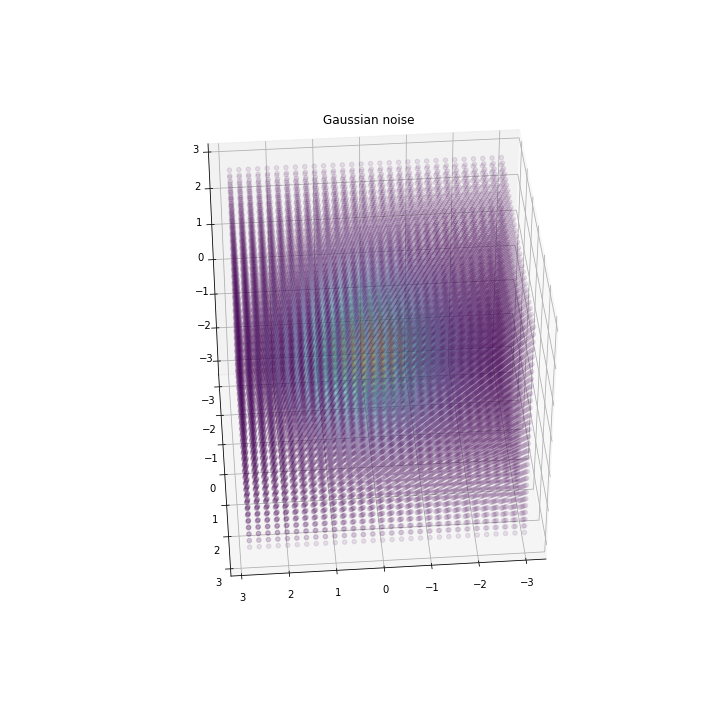

In [31]:
%matplotlib notebook
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm

cmap = cm.viridis


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')



ax.scatter(noise[:,0],noise[:,1],noise[:,2],c=colors,alpha=0.1)
plt.title('Gaussian noise')
plt.show()
plt.show()


In [32]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm



%matplotlib inline



def makePlot(self, GeN,noise, alpha=0.05 ,device=device):
    def get_linewidth(linewidth, axis):
        fig = axis.get_figure()
        ppi = 72  # matplolib points per inches
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())[0]
        return linewidth * ppi * length / value_range
#    nb_samples_plot=theta.shape[0]
    x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 6)
    plt.grid(True, which='major', linewidth=0.5)
    my_lw=get_linewidth(0.2,ax)
#    alpha = (.9 / torch.tensor(float(nb_samples_plot)).sqrt()).clamp(0.05, 1.)
    
    colors=noise[2]
    
    norm=Normalize(vmin=colors.min(), vmax=colors.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    for i in range(colors.shape[0]):
        for j in range(colors.shape[1]):
            xy_noise=torch.Tensor([noise[0][i,j],noise[1][i,j]]).unsqueeze(0).to(device)
            theta=GeN.components[0].hnet(xy_noise).detach()
            y_pred = self._normalized_prediction(x_lin, theta, device)
            color=m.to_rgba(colors[i,j])
            plt.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), alpha=alpha, linewidth=1.0, color=color,zorder=3)
    plt.scatter(self._X_train.cpu(), self._y_train.cpu(), marker='.',color='black',zorder=4)
    return fig



In [33]:
if setup.plot:
    fig=makePlot(setup,GeN,noise, alpha=0.01)


In [34]:
%matplotlib inline
from tempfile import TemporaryDirectory

with TemporaryDirectory() as temp_dir:
    optimizer = GeNVariationalInference(logtarget,
		                                    0, 100, 1000, 50, 100,
		                                    20000, .01, .000001, 500, .5,
		                                    device, True, temp_dir, save_best=True)
    best_epoch, scores=optimizer.run(GeN)
print(best_epoch)

Epoch [0/20000], Loss: 723758.0, Entropy 216.88058471679688, Learning Rate: 0.01
Epoch [1/20000], Loss: 1241614.5, Entropy 195.74867248535156, Learning Rate: 0.01
Epoch [2/20000], Loss: 487467.34375, Entropy 192.08148193359375, Learning Rate: 0.01
Epoch [3/20000], Loss: 334976.21875, Entropy 176.78306579589844, Learning Rate: 0.01
Epoch [4/20000], Loss: 314977.125, Entropy 169.74192810058594, Learning Rate: 0.01
Epoch [5/20000], Loss: 210907.828125, Entropy 138.9728240966797, Learning Rate: 0.01
Epoch [6/20000], Loss: 229237.015625, Entropy 135.26759338378906, Learning Rate: 0.01
Epoch [7/20000], Loss: 125905.609375, Entropy 137.01918029785156, Learning Rate: 0.01
Epoch [8/20000], Loss: 165243.875, Entropy 133.68870544433594, Learning Rate: 0.01
Epoch [9/20000], Loss: 100251.6875, Entropy 113.14781188964844, Learning Rate: 0.01
Epoch [10/20000], Loss: 98115.4375, Entropy 111.21495056152344, Learning Rate: 0.01
Epoch [11/20000], Loss: 73555.7734375, Entropy 96.98065185546875, Learning R

Epoch [97/20000], Loss: 3130.330078125, Entropy -53.892024993896484, Learning Rate: 0.01
Epoch [98/20000], Loss: 2596.9443359375, Entropy -52.62086486816406, Learning Rate: 0.01
Epoch [99/20000], Loss: 2566.133056640625, Entropy -52.31684494018555, Learning Rate: 0.01
Epoch [100/20000], Loss: 2726.84228515625, Entropy -49.60799789428711, Learning Rate: 0.01
Epoch [101/20000], Loss: 2620.067626953125, Entropy -55.878662109375, Learning Rate: 0.01
Epoch [102/20000], Loss: 2394.1865234375, Entropy -55.35234832763672, Learning Rate: 0.01
Epoch [103/20000], Loss: 2836.488525390625, Entropy -74.89437103271484, Learning Rate: 0.01
Epoch [104/20000], Loss: 2517.982666015625, Entropy -60.539100646972656, Learning Rate: 0.01
Epoch [105/20000], Loss: 2365.5185546875, Entropy -63.90717697143555, Learning Rate: 0.01
Epoch [106/20000], Loss: 2408.8330078125, Entropy -63.65753173828125, Learning Rate: 0.01
Epoch [107/20000], Loss: 2584.061279296875, Entropy -56.61248016357422, Learning Rate: 0.01
Epo

Epoch [196/20000], Loss: 1858.144287109375, Entropy -78.40687561035156, Learning Rate: 0.01
Epoch [197/20000], Loss: 1663.6707763671875, Entropy -77.83549499511719, Learning Rate: 0.01
Epoch [198/20000], Loss: 2140.43017578125, Entropy -70.16228485107422, Learning Rate: 0.01
Epoch [199/20000], Loss: 1744.9796142578125, Entropy -85.606689453125, Learning Rate: 0.01
Epoch [200/20000], Loss: 2153.525390625, Entropy -85.88459014892578, Learning Rate: 0.01
Epoch [201/20000], Loss: 1895.1507568359375, Entropy -82.65046691894531, Learning Rate: 0.01
Epoch [202/20000], Loss: 2008.656005859375, Entropy -85.04039001464844, Learning Rate: 0.01
Epoch [203/20000], Loss: 1684.0389404296875, Entropy -75.00527954101562, Learning Rate: 0.01
Epoch [204/20000], Loss: 1723.1573486328125, Entropy -87.46318054199219, Learning Rate: 0.01
Epoch [205/20000], Loss: 1788.3291015625, Entropy -68.13470458984375, Learning Rate: 0.01
Epoch [206/20000], Loss: 1847.178955078125, Entropy -73.4771499633789, Learning Rat

Epoch [295/20000], Loss: 1718.86767578125, Entropy -93.0992202758789, Learning Rate: 0.01
Epoch [296/20000], Loss: 1545.66845703125, Entropy -72.42769622802734, Learning Rate: 0.01
Epoch [297/20000], Loss: 1692.7860107421875, Entropy -80.87246704101562, Learning Rate: 0.01
Epoch [298/20000], Loss: 1577.2723388671875, Entropy -95.0589599609375, Learning Rate: 0.01
Epoch [299/20000], Loss: 1674.562744140625, Entropy -86.4107437133789, Learning Rate: 0.01
Epoch [300/20000], Loss: 1730.0775146484375, Entropy -110.64436340332031, Learning Rate: 0.01
Epoch [301/20000], Loss: 1584.787841796875, Entropy -91.37800598144531, Learning Rate: 0.01
Epoch [302/20000], Loss: 1624.6239013671875, Entropy -94.42450714111328, Learning Rate: 0.01
Epoch [303/20000], Loss: 1768.234130859375, Entropy -88.91099548339844, Learning Rate: 0.01
Epoch [304/20000], Loss: 1655.738525390625, Entropy -80.93913269042969, Learning Rate: 0.01
Epoch [305/20000], Loss: 1614.9185791015625, Entropy -87.98029327392578, Learnin

Epoch [394/20000], Loss: 1424.8494873046875, Entropy -88.51472473144531, Learning Rate: 0.01
Epoch [395/20000], Loss: 1491.1685791015625, Entropy -86.81548309326172, Learning Rate: 0.01
Epoch [396/20000], Loss: 1528.71728515625, Entropy -96.43046569824219, Learning Rate: 0.01
Epoch [397/20000], Loss: 1535.6580810546875, Entropy -87.14049530029297, Learning Rate: 0.01
Epoch [398/20000], Loss: 1538.31787109375, Entropy -89.56903076171875, Learning Rate: 0.01
Epoch [399/20000], Loss: 1594.6868896484375, Entropy -101.94501495361328, Learning Rate: 0.01
Epoch [400/20000], Loss: 1516.3004150390625, Entropy -97.12109375, Learning Rate: 0.01
Epoch [401/20000], Loss: 1512.094482421875, Entropy -71.77357482910156, Learning Rate: 0.01
Epoch [402/20000], Loss: 1555.733154296875, Entropy -78.43064880371094, Learning Rate: 0.01
Epoch [403/20000], Loss: 1514.1678466796875, Entropy -89.68956756591797, Learning Rate: 0.01
Epoch [404/20000], Loss: 1488.8302001953125, Entropy -92.33060455322266, Learning

Epoch [493/20000], Loss: 1393.06640625, Entropy -93.30447387695312, Learning Rate: 0.01
Epoch [494/20000], Loss: 1411.2916259765625, Entropy -89.21968841552734, Learning Rate: 0.01
Epoch [495/20000], Loss: 1342.604736328125, Entropy -76.37319946289062, Learning Rate: 0.01
Epoch [496/20000], Loss: 1466.832275390625, Entropy -96.48213958740234, Learning Rate: 0.01
Epoch [497/20000], Loss: 1374.6373291015625, Entropy -72.22637176513672, Learning Rate: 0.01
Epoch [498/20000], Loss: 1410.5164794921875, Entropy -92.36775970458984, Learning Rate: 0.01
Epoch [499/20000], Loss: 1388.0340576171875, Entropy -85.48954010009766, Learning Rate: 0.01
Epoch [500/20000], Loss: 1406.99267578125, Entropy -80.09550476074219, Learning Rate: 0.01
Epoch [501/20000], Loss: 1335.4056396484375, Entropy -72.7743148803711, Learning Rate: 0.01
Epoch [502/20000], Loss: 1517.300537109375, Entropy -102.14759826660156, Learning Rate: 0.01
Epoch [503/20000], Loss: 1411.7630615234375, Entropy -89.9994125366211, Learning

Epoch [591/20000], Loss: 1390.339599609375, Entropy -74.99195861816406, Learning Rate: 0.01
Epoch [592/20000], Loss: 1352.342041015625, Entropy -65.25737762451172, Learning Rate: 0.01
Epoch [593/20000], Loss: 1379.1834716796875, Entropy -63.25540542602539, Learning Rate: 0.01
Epoch [594/20000], Loss: 1359.0523681640625, Entropy -68.0275650024414, Learning Rate: 0.01
Epoch [595/20000], Loss: 1453.2158203125, Entropy -83.05775451660156, Learning Rate: 0.01
Epoch [596/20000], Loss: 1399.2159423828125, Entropy -96.61528778076172, Learning Rate: 0.01
Epoch [597/20000], Loss: 1296.0364990234375, Entropy -67.5766372680664, Learning Rate: 0.01
Epoch [598/20000], Loss: 1330.734619140625, Entropy -86.61073303222656, Learning Rate: 0.01
Epoch [599/20000], Loss: 1393.7266845703125, Entropy -90.6708755493164, Learning Rate: 0.01
Epoch [600/20000], Loss: 1408.5433349609375, Entropy -66.5844497680664, Learning Rate: 0.01
Epoch [601/20000], Loss: 1371.947021484375, Entropy -76.9684829711914, Learning 

Epoch [690/20000], Loss: 1376.4716796875, Entropy -58.50550079345703, Learning Rate: 0.01
Epoch [691/20000], Loss: 1360.3348388671875, Entropy -66.39859771728516, Learning Rate: 0.01
Epoch [692/20000], Loss: 1461.57421875, Entropy -53.76361083984375, Learning Rate: 0.01
Epoch [693/20000], Loss: 1305.87548828125, Entropy -67.36639404296875, Learning Rate: 0.01
Epoch [694/20000], Loss: 1447.0262451171875, Entropy -82.15894317626953, Learning Rate: 0.01
Epoch [695/20000], Loss: 1498.826416015625, Entropy -61.64895248413086, Learning Rate: 0.01
Epoch [696/20000], Loss: 1321.406982421875, Entropy -51.30025100708008, Learning Rate: 0.01
Epoch [697/20000], Loss: 1591.92626953125, Entropy -58.57222366333008, Learning Rate: 0.01
Epoch [698/20000], Loss: 1429.354248046875, Entropy -65.20136260986328, Learning Rate: 0.01
Epoch [699/20000], Loss: 1689.991943359375, Entropy -59.558074951171875, Learning Rate: 0.01
Epoch [700/20000], Loss: 1353.3077392578125, Entropy -70.52838897705078, Learning Rat

Epoch [789/20000], Loss: 1509.3765869140625, Entropy -41.99851989746094, Learning Rate: 0.01
Epoch [790/20000], Loss: 1241.90283203125, Entropy -42.44171905517578, Learning Rate: 0.01
Epoch [791/20000], Loss: 1340.9569091796875, Entropy -65.84477233886719, Learning Rate: 0.01
Epoch [792/20000], Loss: 1294.8316650390625, Entropy -63.27718734741211, Learning Rate: 0.01
Epoch [793/20000], Loss: 1345.231689453125, Entropy -63.54241943359375, Learning Rate: 0.01
Epoch [794/20000], Loss: 1259.8822021484375, Entropy -43.497520446777344, Learning Rate: 0.01
Epoch [795/20000], Loss: 1302.9852294921875, Entropy -46.707923889160156, Learning Rate: 0.01
Epoch [796/20000], Loss: 1429.4169921875, Entropy -47.66912078857422, Learning Rate: 0.01
Epoch [797/20000], Loss: 1337.2999267578125, Entropy -47.85294723510742, Learning Rate: 0.01
Epoch [798/20000], Loss: 1374.1219482421875, Entropy -50.58319854736328, Learning Rate: 0.01
Epoch [799/20000], Loss: 1375.6351318359375, Entropy -37.11148452758789, L

Epoch [888/20000], Loss: 1273.6407470703125, Entropy -45.237030029296875, Learning Rate: 0.01
Epoch [889/20000], Loss: 1222.06298828125, Entropy -27.67951774597168, Learning Rate: 0.01
Epoch [890/20000], Loss: 1271.9788818359375, Entropy -22.37531280517578, Learning Rate: 0.01
Epoch [891/20000], Loss: 1264.0919189453125, Entropy -42.733787536621094, Learning Rate: 0.01
Epoch [892/20000], Loss: 1282.7454833984375, Entropy -43.63420867919922, Learning Rate: 0.01
Epoch [893/20000], Loss: 1273.2476806640625, Entropy -38.438133239746094, Learning Rate: 0.01
Epoch [894/20000], Loss: 1282.3720703125, Entropy -53.10859680175781, Learning Rate: 0.01
Epoch [895/20000], Loss: 1274.2900390625, Entropy -40.19575119018555, Learning Rate: 0.01
Epoch [896/20000], Loss: 1224.620849609375, Entropy -48.184242248535156, Learning Rate: 0.01
Epoch [897/20000], Loss: 1273.0377197265625, Entropy -35.786380767822266, Learning Rate: 0.01
Epoch [898/20000], Loss: 1326.7894287109375, Entropy -47.3312873840332, Le

Epoch [987/20000], Loss: 1200.8768310546875, Entropy -31.48019790649414, Learning Rate: 0.01
Epoch [988/20000], Loss: 1269.4432373046875, Entropy -30.303434371948242, Learning Rate: 0.01
Epoch [989/20000], Loss: 1241.6820068359375, Entropy -27.268470764160156, Learning Rate: 0.01
Epoch [990/20000], Loss: 1237.7337646484375, Entropy -29.765575408935547, Learning Rate: 0.01
Epoch [991/20000], Loss: 1282.948974609375, Entropy -25.56599998474121, Learning Rate: 0.01
Epoch [992/20000], Loss: 1217.4310302734375, Entropy -22.72678565979004, Learning Rate: 0.01
Epoch [993/20000], Loss: 1252.4173583984375, Entropy -19.84901237487793, Learning Rate: 0.01
Epoch [994/20000], Loss: 1338.3353271484375, Entropy -36.72761535644531, Learning Rate: 0.01
Epoch [995/20000], Loss: 1259.5572509765625, Entropy -32.881126403808594, Learning Rate: 0.01
Epoch [996/20000], Loss: 1222.2137451171875, Entropy -28.95254898071289, Learning Rate: 0.01
Epoch [997/20000], Loss: 1273.5062255859375, Entropy -28.0495033264

Epoch [1075/20000], Loss: 1267.067138671875, Entropy -36.08589172363281, Learning Rate: 0.01
Epoch [1076/20000], Loss: 1266.839599609375, Entropy -13.732600212097168, Learning Rate: 0.01
Epoch [1077/20000], Loss: 1248.8175048828125, Entropy -16.37427520751953, Learning Rate: 0.01
Epoch [1078/20000], Loss: 1401.608154296875, Entropy -36.52135467529297, Learning Rate: 0.01
Epoch [1079/20000], Loss: 1234.4505615234375, Entropy -13.160798072814941, Learning Rate: 0.01
Epoch [1080/20000], Loss: 1292.684814453125, Entropy -8.70316219329834, Learning Rate: 0.01
Epoch [1081/20000], Loss: 1240.1844482421875, Entropy -26.51197052001953, Learning Rate: 0.01
Epoch [1082/20000], Loss: 1270.690673828125, Entropy -12.98173999786377, Learning Rate: 0.01
Epoch [1083/20000], Loss: 1216.8780517578125, Entropy -21.884246826171875, Learning Rate: 0.01
Epoch [1084/20000], Loss: 1207.30810546875, Entropy -9.440372467041016, Learning Rate: 0.01
Epoch [1085/20000], Loss: 1262.723388671875, Entropy 0.6178718805

Epoch [1173/20000], Loss: 1231.9864501953125, Entropy -6.337256908416748, Learning Rate: 0.01
Epoch [1174/20000], Loss: 1220.413330078125, Entropy 6.473458766937256, Learning Rate: 0.01
Epoch [1175/20000], Loss: 1182.2401123046875, Entropy -1.630181074142456, Learning Rate: 0.01
Epoch [1176/20000], Loss: 1260.8406982421875, Entropy 2.7893810272216797, Learning Rate: 0.01
Epoch [1177/20000], Loss: 1237.332275390625, Entropy 6.989861488342285, Learning Rate: 0.01
Epoch [1178/20000], Loss: 1272.5123291015625, Entropy 6.179318904876709, Learning Rate: 0.01
Epoch [1179/20000], Loss: 1192.1917724609375, Entropy -6.656269550323486, Learning Rate: 0.01
Epoch [1180/20000], Loss: 1178.3712158203125, Entropy 11.031246185302734, Learning Rate: 0.01
Epoch [1181/20000], Loss: 1306.6820068359375, Entropy 13.233129501342773, Learning Rate: 0.01
Epoch [1182/20000], Loss: 1277.0888671875, Entropy 6.792548179626465, Learning Rate: 0.01
Epoch [1183/20000], Loss: 1256.2611083984375, Entropy 1.5824252367019

Epoch [1272/20000], Loss: 1240.3740234375, Entropy 17.9704532623291, Learning Rate: 0.01
Epoch [1273/20000], Loss: 1225.077880859375, Entropy 23.836299896240234, Learning Rate: 0.01
Epoch [1274/20000], Loss: 1186.938232421875, Entropy 21.463298797607422, Learning Rate: 0.01
Epoch [1275/20000], Loss: 1282.7403564453125, Entropy 21.079137802124023, Learning Rate: 0.01
Epoch [1276/20000], Loss: 1205.550048828125, Entropy 23.04073143005371, Learning Rate: 0.01
Epoch [1277/20000], Loss: 1185.598388671875, Entropy 7.157711505889893, Learning Rate: 0.01
Epoch [1278/20000], Loss: 1182.9267578125, Entropy 19.77981948852539, Learning Rate: 0.01
Epoch [1279/20000], Loss: 1229.2359619140625, Entropy -0.9347698092460632, Learning Rate: 0.01
Epoch [1280/20000], Loss: 1196.9462890625, Entropy 12.811198234558105, Learning Rate: 0.01
Epoch [1281/20000], Loss: 1261.5853271484375, Entropy 21.006759643554688, Learning Rate: 0.01
Epoch [1282/20000], Loss: 1216.265869140625, Entropy 16.67825698852539, Learn

Epoch [1371/20000], Loss: 1221.0101318359375, Entropy 22.489030838012695, Learning Rate: 0.01
Epoch [1372/20000], Loss: 1327.660888671875, Entropy 3.6323602199554443, Learning Rate: 0.01
Epoch [1373/20000], Loss: 1249.9923095703125, Entropy 14.848730087280273, Learning Rate: 0.01
Epoch [1374/20000], Loss: 1318.9273681640625, Entropy 17.535137176513672, Learning Rate: 0.01
Epoch [1375/20000], Loss: 1262.1109619140625, Entropy 14.796182632446289, Learning Rate: 0.01
Epoch [1376/20000], Loss: 1241.291259765625, Entropy 14.542880058288574, Learning Rate: 0.01
Epoch [1377/20000], Loss: 1248.7724609375, Entropy 16.235563278198242, Learning Rate: 0.01
Epoch [1378/20000], Loss: 1212.2552490234375, Entropy 20.63234519958496, Learning Rate: 0.01
Epoch [1379/20000], Loss: 1257.8265380859375, Entropy 25.742820739746094, Learning Rate: 0.01
Epoch [1380/20000], Loss: 1222.283203125, Entropy 14.675132751464844, Learning Rate: 0.01
Epoch [1381/20000], Loss: 1214.77685546875, Entropy 21.267988204956055

Epoch [1470/20000], Loss: 1191.2596435546875, Entropy 40.42884063720703, Learning Rate: 0.01
Epoch [1471/20000], Loss: 1169.237060546875, Entropy 36.607948303222656, Learning Rate: 0.01
Epoch [1472/20000], Loss: 1181.0701904296875, Entropy 43.40963363647461, Learning Rate: 0.01
Epoch [1473/20000], Loss: 1128.5115966796875, Entropy 52.50603485107422, Learning Rate: 0.01
Epoch [1474/20000], Loss: 1122.4041748046875, Entropy 34.44355773925781, Learning Rate: 0.01
Epoch [1475/20000], Loss: 1173.3992919921875, Entropy 21.261098861694336, Learning Rate: 0.01
Epoch [1476/20000], Loss: 1138.798095703125, Entropy 45.12257766723633, Learning Rate: 0.01
Epoch [1477/20000], Loss: 1179.23583984375, Entropy 37.591880798339844, Learning Rate: 0.01
Epoch [1478/20000], Loss: 1175.2838134765625, Entropy 32.54233169555664, Learning Rate: 0.01
Epoch [1479/20000], Loss: 1199.7437744140625, Entropy 23.596914291381836, Learning Rate: 0.01
Epoch [1480/20000], Loss: 1170.3343505859375, Entropy 36.8727989196777

Epoch [1569/20000], Loss: 1374.9085693359375, Entropy 51.06199264526367, Learning Rate: 0.01
Epoch [1570/20000], Loss: 1457.9085693359375, Entropy 48.17400360107422, Learning Rate: 0.01
Epoch [1571/20000], Loss: 1199.1763916015625, Entropy 56.662376403808594, Learning Rate: 0.01
Epoch [1572/20000], Loss: 1255.649169921875, Entropy 45.61473083496094, Learning Rate: 0.01
Epoch [1573/20000], Loss: 1270.70556640625, Entropy 39.51274108886719, Learning Rate: 0.01
Epoch [1574/20000], Loss: 1202.611572265625, Entropy 40.54389190673828, Learning Rate: 0.01
Epoch [1575/20000], Loss: 1260.568115234375, Entropy 52.446311950683594, Learning Rate: 0.01
Epoch [1576/20000], Loss: 1195.258056640625, Entropy 49.58601379394531, Learning Rate: 0.01
Epoch [1577/20000], Loss: 1233.7947998046875, Entropy 35.13193130493164, Learning Rate: 0.01
Epoch [1578/20000], Loss: 1262.9949951171875, Entropy 41.6039924621582, Learning Rate: 0.01
Epoch [1579/20000], Loss: 1242.5218505859375, Entropy 44.58864212036133, Le

Epoch [1668/20000], Loss: 1151.832763671875, Entropy 64.66053771972656, Learning Rate: 0.01
Epoch [1669/20000], Loss: 1125.0662841796875, Entropy 72.83049011230469, Learning Rate: 0.01
Epoch [1670/20000], Loss: 1163.7801513671875, Entropy 52.38936233520508, Learning Rate: 0.01
Epoch [1671/20000], Loss: 1136.620849609375, Entropy 65.81414794921875, Learning Rate: 0.01
Epoch [1672/20000], Loss: 1167.027099609375, Entropy 64.41658020019531, Learning Rate: 0.01
Epoch [1673/20000], Loss: 1150.3651123046875, Entropy 71.76222229003906, Learning Rate: 0.01
Epoch [1674/20000], Loss: 1147.738525390625, Entropy 64.26493072509766, Learning Rate: 0.01
Epoch [1675/20000], Loss: 1135.32275390625, Entropy 61.22714614868164, Learning Rate: 0.01
Epoch [1676/20000], Loss: 1226.9388427734375, Entropy 71.92134857177734, Learning Rate: 0.01
Epoch [1677/20000], Loss: 1230.746826171875, Entropy 68.7297592163086, Learning Rate: 0.01
Epoch [1678/20000], Loss: 1184.45068359375, Entropy 45.97257614135742, Learnin

Epoch [1767/20000], Loss: 1123.81494140625, Entropy 66.60319519042969, Learning Rate: 0.01
Epoch [1768/20000], Loss: 1154.1251220703125, Entropy 70.09040069580078, Learning Rate: 0.01
Epoch [1769/20000], Loss: 1109.5382080078125, Entropy 75.9444580078125, Learning Rate: 0.01
Epoch [1770/20000], Loss: 1136.6207275390625, Entropy 76.27076721191406, Learning Rate: 0.01
Epoch [1771/20000], Loss: 1125.97265625, Entropy 87.43751525878906, Learning Rate: 0.01
Epoch [1772/20000], Loss: 1120.179443359375, Entropy 72.88023376464844, Learning Rate: 0.01
Epoch [1773/20000], Loss: 1114.2047119140625, Entropy 84.9273452758789, Learning Rate: 0.01
Epoch [1774/20000], Loss: 1229.05419921875, Entropy 52.02545928955078, Learning Rate: 0.01
Epoch [1775/20000], Loss: 1368.6844482421875, Entropy 64.6465835571289, Learning Rate: 0.01
Epoch [1776/20000], Loss: 1189.045166015625, Entropy 60.375457763671875, Learning Rate: 0.01
Epoch [1777/20000], Loss: 1200.499755859375, Entropy 71.86327362060547, Learning Ra

Epoch [1866/20000], Loss: 1109.2989501953125, Entropy 98.1709976196289, Learning Rate: 0.01
Epoch [1867/20000], Loss: 1127.234619140625, Entropy 75.46217346191406, Learning Rate: 0.01
Epoch [1868/20000], Loss: 1059.259033203125, Entropy 94.03079986572266, Learning Rate: 0.01
Epoch [1869/20000], Loss: 1088.4141845703125, Entropy 102.53784942626953, Learning Rate: 0.01
Epoch [1870/20000], Loss: 1089.15283203125, Entropy 98.7496566772461, Learning Rate: 0.01
Epoch [1871/20000], Loss: 1139.395751953125, Entropy 79.69364929199219, Learning Rate: 0.01
Epoch [1872/20000], Loss: 1101.32373046875, Entropy 92.28977966308594, Learning Rate: 0.01
Epoch [1873/20000], Loss: 1071.0196533203125, Entropy 97.41739654541016, Learning Rate: 0.01
Epoch [1874/20000], Loss: 1100.210205078125, Entropy 86.56612396240234, Learning Rate: 0.01
Epoch [1875/20000], Loss: 1088.212890625, Entropy 97.39810180664062, Learning Rate: 0.01
Epoch [1876/20000], Loss: 1165.315673828125, Entropy 76.1139144897461, Learning Rat

Epoch [1965/20000], Loss: 1657.1004638671875, Entropy 86.3756103515625, Learning Rate: 0.01
Epoch [1966/20000], Loss: 1219.8450927734375, Entropy 94.58634185791016, Learning Rate: 0.01
Epoch [1967/20000], Loss: 1837.504638671875, Entropy 84.50814056396484, Learning Rate: 0.01
Epoch [1968/20000], Loss: 1166.8966064453125, Entropy 83.01651000976562, Learning Rate: 0.01
Epoch [1969/20000], Loss: 1764.7935791015625, Entropy 88.9369125366211, Learning Rate: 0.01
Epoch [1970/20000], Loss: 1168.1431884765625, Entropy 84.82279205322266, Learning Rate: 0.01
Epoch [1971/20000], Loss: 1653.9681396484375, Entropy 84.05374145507812, Learning Rate: 0.01
Epoch [1972/20000], Loss: 1352.8648681640625, Entropy 90.27212524414062, Learning Rate: 0.01
Epoch [1973/20000], Loss: 1475.9212646484375, Entropy 98.4799575805664, Learning Rate: 0.01
Epoch [1974/20000], Loss: 1797.98779296875, Entropy 86.0683364868164, Learning Rate: 0.01
Epoch [1975/20000], Loss: 1913.3624267578125, Entropy 88.811279296875, Learni

Epoch [2064/20000], Loss: 1138.5272216796875, Entropy 44.62822341918945, Learning Rate: 0.01
Epoch [2065/20000], Loss: 1142.9403076171875, Entropy 42.011199951171875, Learning Rate: 0.01
Epoch [2066/20000], Loss: 1101.6531982421875, Entropy 59.799617767333984, Learning Rate: 0.01
Epoch [2067/20000], Loss: 1146.6788330078125, Entropy 46.355751037597656, Learning Rate: 0.01
Epoch [2068/20000], Loss: 1117.083251953125, Entropy 59.590946197509766, Learning Rate: 0.01
Epoch [2069/20000], Loss: 1101.46533203125, Entropy 55.592166900634766, Learning Rate: 0.01
Epoch [2070/20000], Loss: 1124.3828125, Entropy 50.018333435058594, Learning Rate: 0.01
Epoch [2071/20000], Loss: 1120.0755615234375, Entropy 44.56114959716797, Learning Rate: 0.01
Epoch [2072/20000], Loss: 1122.6807861328125, Entropy 41.219329833984375, Learning Rate: 0.01
Epoch [2073/20000], Loss: 1105.3812255859375, Entropy 51.23972702026367, Learning Rate: 0.01
Epoch [2074/20000], Loss: 1154.919921875, Entropy 40.46921920776367, Lea

Epoch [2163/20000], Loss: 1105.46142578125, Entropy 76.5443115234375, Learning Rate: 0.01
Epoch [2164/20000], Loss: 1059.1024169921875, Entropy 90.5694351196289, Learning Rate: 0.01
Epoch [2165/20000], Loss: 1095.66455078125, Entropy 87.22103118896484, Learning Rate: 0.01
Epoch [2166/20000], Loss: 1104.114501953125, Entropy 84.93234252929688, Learning Rate: 0.01
Epoch [2167/20000], Loss: 1089.1517333984375, Entropy 95.46369934082031, Learning Rate: 0.01
Epoch [2168/20000], Loss: 1085.7227783203125, Entropy 84.71663665771484, Learning Rate: 0.01
Epoch [2169/20000], Loss: 1084.24658203125, Entropy 94.27214813232422, Learning Rate: 0.01
Epoch [2170/20000], Loss: 1093.33056640625, Entropy 73.89232635498047, Learning Rate: 0.01
Epoch [2171/20000], Loss: 1092.7906494140625, Entropy 97.81880950927734, Learning Rate: 0.01
Epoch [2172/20000], Loss: 1094.2529296875, Entropy 90.25261688232422, Learning Rate: 0.01
Epoch [2173/20000], Loss: 1105.131103515625, Entropy 83.82465362548828, Learning Rat

Epoch [2262/20000], Loss: 1070.026123046875, Entropy 113.2636489868164, Learning Rate: 0.01
Epoch [2263/20000], Loss: 1098.06396484375, Entropy 117.55480194091797, Learning Rate: 0.01
Epoch [2264/20000], Loss: 1072.5360107421875, Entropy 123.42677307128906, Learning Rate: 0.01
Epoch [2265/20000], Loss: 1083.52294921875, Entropy 115.99122619628906, Learning Rate: 0.01
Epoch [2266/20000], Loss: 1083.30810546875, Entropy 123.45262145996094, Learning Rate: 0.01
Epoch [2267/20000], Loss: 1088.5048828125, Entropy 105.82158660888672, Learning Rate: 0.01
Epoch [2268/20000], Loss: 1067.3914794921875, Entropy 114.32882690429688, Learning Rate: 0.01
Epoch [2269/20000], Loss: 1072.7166748046875, Entropy 118.98658752441406, Learning Rate: 0.01
Epoch [2270/20000], Loss: 1059.8858642578125, Entropy 113.64116668701172, Learning Rate: 0.01
Epoch [2271/20000], Loss: 1100.8477783203125, Entropy 111.5976333618164, Learning Rate: 0.01
Epoch [2272/20000], Loss: 1049.1070556640625, Entropy 131.89100646972656

Epoch [2361/20000], Loss: 1084.863037109375, Entropy 126.8134994506836, Learning Rate: 0.01
Epoch [2362/20000], Loss: 1103.9447021484375, Entropy 136.2898712158203, Learning Rate: 0.01
Epoch [2363/20000], Loss: 1050.220947265625, Entropy 141.67686462402344, Learning Rate: 0.01
Epoch [2364/20000], Loss: 1173.3184814453125, Entropy 139.09580993652344, Learning Rate: 0.01
Epoch [2365/20000], Loss: 1105.124267578125, Entropy 127.85101318359375, Learning Rate: 0.01
Epoch [2366/20000], Loss: 1124.1337890625, Entropy 152.32989501953125, Learning Rate: 0.01
Epoch [2367/20000], Loss: 1157.568115234375, Entropy 135.3076934814453, Learning Rate: 0.01
Epoch [2368/20000], Loss: 1055.3419189453125, Entropy 137.7305145263672, Learning Rate: 0.01
Epoch [2369/20000], Loss: 1093.869140625, Entropy 145.44749450683594, Learning Rate: 0.01
Epoch [2370/20000], Loss: 1126.312255859375, Entropy 121.10933685302734, Learning Rate: 0.01
Epoch [2371/20000], Loss: 1052.43408203125, Entropy 140.1158905029297, Learn

Epoch [2459/20000], Loss: 1151.04248046875, Entropy 142.78382873535156, Learning Rate: 0.01
Epoch [2460/20000], Loss: 1228.9151611328125, Entropy 156.60107421875, Learning Rate: 0.01
Epoch [2461/20000], Loss: 1197.574462890625, Entropy 147.52972412109375, Learning Rate: 0.01
Epoch [2462/20000], Loss: 1120.5638427734375, Entropy 156.12667846679688, Learning Rate: 0.01
Epoch [2463/20000], Loss: 1140.2664794921875, Entropy 142.7588348388672, Learning Rate: 0.01
Epoch [2464/20000], Loss: 1120.1796875, Entropy 165.23275756835938, Learning Rate: 0.01
Epoch [2465/20000], Loss: 1106.3726806640625, Entropy 160.91049194335938, Learning Rate: 0.01
Epoch [2466/20000], Loss: 1233.4884033203125, Entropy 158.65879821777344, Learning Rate: 0.01
Epoch [2467/20000], Loss: 1200.4246826171875, Entropy 146.53370666503906, Learning Rate: 0.01
Epoch [2468/20000], Loss: 1354.34716796875, Entropy 160.99935913085938, Learning Rate: 0.01
Epoch [2469/20000], Loss: 1176.36865234375, Entropy 155.4933624267578, Lear

Epoch [2558/20000], Loss: 1095.981201171875, Entropy 102.49769592285156, Learning Rate: 0.01
Epoch [2559/20000], Loss: 1271.049072265625, Entropy 100.53558349609375, Learning Rate: 0.01
Epoch [2560/20000], Loss: 1125.282958984375, Entropy 105.60787200927734, Learning Rate: 0.01
Epoch [2561/20000], Loss: 1178.043701171875, Entropy 96.7028579711914, Learning Rate: 0.01
Epoch [2562/20000], Loss: 1173.0322265625, Entropy 115.8358383178711, Learning Rate: 0.01
Epoch [2563/20000], Loss: 1106.2784423828125, Entropy 104.13124084472656, Learning Rate: 0.01
Epoch [2564/20000], Loss: 1221.677490234375, Entropy 101.02526092529297, Learning Rate: 0.01
Epoch [2565/20000], Loss: 1134.0411376953125, Entropy 117.8110122680664, Learning Rate: 0.01
Epoch [2566/20000], Loss: 1147.434326171875, Entropy 107.57594299316406, Learning Rate: 0.01
Epoch [2567/20000], Loss: 1179.3846435546875, Entropy 104.41098022460938, Learning Rate: 0.01
Epoch [2568/20000], Loss: 1062.776611328125, Entropy 107.85163116455078, 

Epoch [2657/20000], Loss: 1054.4708251953125, Entropy 139.21104431152344, Learning Rate: 0.01
Epoch [2658/20000], Loss: 1024.645751953125, Entropy 144.78466796875, Learning Rate: 0.01
Epoch [2659/20000], Loss: 1052.85107421875, Entropy 136.35479736328125, Learning Rate: 0.01
Epoch [2660/20000], Loss: 1059.1409912109375, Entropy 133.83447265625, Learning Rate: 0.01
Epoch [2661/20000], Loss: 1037.3642578125, Entropy 143.28611755371094, Learning Rate: 0.01
Epoch [2662/20000], Loss: 1058.9227294921875, Entropy 144.43226623535156, Learning Rate: 0.01
Epoch [2663/20000], Loss: 1039.4688720703125, Entropy 137.26248168945312, Learning Rate: 0.01
Epoch [2664/20000], Loss: 1030.895751953125, Entropy 140.50743103027344, Learning Rate: 0.01
Epoch [2665/20000], Loss: 1072.71142578125, Entropy 136.49610900878906, Learning Rate: 0.01
Epoch [2666/20000], Loss: 1003.3762817382812, Entropy 160.87103271484375, Learning Rate: 0.01
Epoch [2667/20000], Loss: 1045.234130859375, Entropy 138.13514709472656, Le

Epoch [2756/20000], Loss: 1095.9940185546875, Entropy 172.78921508789062, Learning Rate: 0.01
Epoch [2757/20000], Loss: 1124.554931640625, Entropy 165.20411682128906, Learning Rate: 0.01
Epoch [2758/20000], Loss: 1107.1800537109375, Entropy 168.4753875732422, Learning Rate: 0.01
Epoch [2759/20000], Loss: 1051.013916015625, Entropy 160.27366638183594, Learning Rate: 0.01
Epoch [2760/20000], Loss: 1311.15625, Entropy 158.28086853027344, Learning Rate: 0.01
Epoch [2761/20000], Loss: 1430.6822509765625, Entropy 174.625732421875, Learning Rate: 0.01
Epoch [2762/20000], Loss: 1086.464599609375, Entropy 157.90060424804688, Learning Rate: 0.01
Epoch [2763/20000], Loss: 1299.1424560546875, Entropy 173.21031188964844, Learning Rate: 0.01
Epoch [2764/20000], Loss: 1136.46630859375, Entropy 154.15704345703125, Learning Rate: 0.01
Epoch [2765/20000], Loss: 1219.399169921875, Entropy 170.59803771972656, Learning Rate: 0.01
Epoch [2766/20000], Loss: 1130.701416015625, Entropy 172.31390380859375, Lear

Epoch [2855/20000], Loss: 1225.3038330078125, Entropy 3.2601284980773926, Learning Rate: 0.01
Epoch [2856/20000], Loss: 1194.9461669921875, Entropy 9.126415252685547, Learning Rate: 0.01
Epoch [2857/20000], Loss: 1235.163818359375, Entropy 11.579252243041992, Learning Rate: 0.01
Epoch [2858/20000], Loss: 1211.9559326171875, Entropy 3.684760093688965, Learning Rate: 0.01
Epoch [2859/20000], Loss: 1233.1480712890625, Entropy 6.560944080352783, Learning Rate: 0.01
Epoch [2860/20000], Loss: 1240.05419921875, Entropy -0.14745604991912842, Learning Rate: 0.01
Epoch [2861/20000], Loss: 1188.242431640625, Entropy -2.6830191612243652, Learning Rate: 0.01
Epoch [2862/20000], Loss: 1157.8795166015625, Entropy 10.181020736694336, Learning Rate: 0.01
Epoch [2863/20000], Loss: 1203.8507080078125, Entropy -3.7785637378692627, Learning Rate: 0.01
Epoch [2864/20000], Loss: 1218.4146728515625, Entropy -1.5831905603408813, Learning Rate: 0.01
Epoch [2865/20000], Loss: 1175.0625, Entropy 10.05333232879638

Epoch [2954/20000], Loss: 1112.6700439453125, Entropy 65.06038665771484, Learning Rate: 0.01
Epoch [2955/20000], Loss: 1104.19677734375, Entropy 59.232303619384766, Learning Rate: 0.01
Epoch [2956/20000], Loss: 1079.293212890625, Entropy 77.44058990478516, Learning Rate: 0.01
Epoch [2957/20000], Loss: 1126.88525390625, Entropy 54.117835998535156, Learning Rate: 0.01
Epoch [2958/20000], Loss: 1102.53662109375, Entropy 64.04171752929688, Learning Rate: 0.01
Epoch [2959/20000], Loss: 1090.606201171875, Entropy 66.86751556396484, Learning Rate: 0.01
Epoch [2960/20000], Loss: 1082.5615234375, Entropy 83.17362976074219, Learning Rate: 0.01
Epoch [2961/20000], Loss: 1119.2410888671875, Entropy 56.94859313964844, Learning Rate: 0.01
Epoch [2962/20000], Loss: 1056.8878173828125, Entropy 85.18560028076172, Learning Rate: 0.01
Epoch [2963/20000], Loss: 1094.99267578125, Entropy 82.5951156616211, Learning Rate: 0.01
Epoch [2964/20000], Loss: 1081.86279296875, Entropy 74.48562622070312, Learning Ra

Epoch [3053/20000], Loss: 1051.2935791015625, Entropy 129.66371154785156, Learning Rate: 0.01
Epoch [3054/20000], Loss: 1035.8531494140625, Entropy 136.41624450683594, Learning Rate: 0.01
Epoch [3055/20000], Loss: 1014.4884033203125, Entropy 148.61947631835938, Learning Rate: 0.01
Epoch [3056/20000], Loss: 1079.1402587890625, Entropy 114.78559112548828, Learning Rate: 0.01
Epoch [3057/20000], Loss: 1066.481689453125, Entropy 120.21272277832031, Learning Rate: 0.01
Epoch [3058/20000], Loss: 1095.3878173828125, Entropy 136.70091247558594, Learning Rate: 0.01
Epoch [3059/20000], Loss: 1052.2425537109375, Entropy 124.52464294433594, Learning Rate: 0.01
Epoch [3060/20000], Loss: 1098.877197265625, Entropy 149.0066680908203, Learning Rate: 0.01
Epoch [3061/20000], Loss: 1068.5068359375, Entropy 128.83363342285156, Learning Rate: 0.01
Epoch [3062/20000], Loss: 1063.00927734375, Entropy 162.07113647460938, Learning Rate: 0.01
Epoch [3063/20000], Loss: 1047.1800537109375, Entropy 136.7848968505

Epoch [3152/20000], Loss: 1073.777099609375, Entropy 183.20635986328125, Learning Rate: 0.01
Epoch [3153/20000], Loss: 1072.0142822265625, Entropy 177.0247802734375, Learning Rate: 0.01
Epoch [3154/20000], Loss: 1055.10302734375, Entropy 175.20550537109375, Learning Rate: 0.01
Epoch [3155/20000], Loss: 1062.9593505859375, Entropy 162.49349975585938, Learning Rate: 0.01
Epoch [3156/20000], Loss: 1159.8953857421875, Entropy 164.15724182128906, Learning Rate: 0.01
Epoch [3157/20000], Loss: 1080.191650390625, Entropy 183.9344024658203, Learning Rate: 0.01
Epoch [3158/20000], Loss: 1152.01904296875, Entropy 167.33694458007812, Learning Rate: 0.01
Epoch [3159/20000], Loss: 1098.8958740234375, Entropy 164.46630859375, Learning Rate: 0.01
Epoch [3160/20000], Loss: 1195.4527587890625, Entropy 170.1669158935547, Learning Rate: 0.01
Epoch [3161/20000], Loss: 1051.8521728515625, Entropy 165.82777404785156, Learning Rate: 0.01
Epoch [3162/20000], Loss: 1147.089599609375, Entropy 169.3400421142578, 

Epoch [3251/20000], Loss: 1088.175537109375, Entropy 129.80079650878906, Learning Rate: 0.01
Epoch [3252/20000], Loss: 1083.28564453125, Entropy 148.49465942382812, Learning Rate: 0.01
Epoch [3253/20000], Loss: 1091.23388671875, Entropy 147.58517456054688, Learning Rate: 0.01
Epoch [3254/20000], Loss: 1171.1533203125, Entropy 157.93780517578125, Learning Rate: 0.01
Epoch [3255/20000], Loss: 1082.943603515625, Entropy 142.3082733154297, Learning Rate: 0.01
Epoch [3256/20000], Loss: 1133.1058349609375, Entropy 148.54063415527344, Learning Rate: 0.01
Epoch [3257/20000], Loss: 1026.988037109375, Entropy 157.33506774902344, Learning Rate: 0.01
Epoch [3258/20000], Loss: 1040.880615234375, Entropy 155.06689453125, Learning Rate: 0.01
Epoch [3259/20000], Loss: 1125.283447265625, Entropy 154.07325744628906, Learning Rate: 0.01
Epoch [3260/20000], Loss: 1114.160888671875, Entropy 133.18649291992188, Learning Rate: 0.01
Epoch [3261/20000], Loss: 1063.0673828125, Entropy 147.59954833984375, Learni

Epoch [3350/20000], Loss: 1031.7208251953125, Entropy 168.97915649414062, Learning Rate: 0.01
Epoch [3351/20000], Loss: 1220.99951171875, Entropy 166.8273468017578, Learning Rate: 0.01
Epoch [3352/20000], Loss: 1086.54931640625, Entropy 181.0740203857422, Learning Rate: 0.01
Epoch [3353/20000], Loss: 1153.56005859375, Entropy 181.908203125, Learning Rate: 0.01
Epoch [3354/20000], Loss: 1025.1038818359375, Entropy 188.68527221679688, Learning Rate: 0.01
Epoch [3355/20000], Loss: 1170.00439453125, Entropy 187.1781463623047, Learning Rate: 0.01
Epoch [3356/20000], Loss: 1022.5728759765625, Entropy 175.85812377929688, Learning Rate: 0.01
Epoch [3357/20000], Loss: 1116.2698974609375, Entropy 172.6614227294922, Learning Rate: 0.01
Epoch [3358/20000], Loss: 1038.397216796875, Entropy 174.80465698242188, Learning Rate: 0.01
Epoch [3359/20000], Loss: 1056.923095703125, Entropy 173.71478271484375, Learning Rate: 0.01
Epoch [3360/20000], Loss: 1020.3974609375, Entropy 184.34866333007812, Learning

Epoch [3449/20000], Loss: 987.054443359375, Entropy 206.59378051757812, Learning Rate: 0.01
Epoch [3450/20000], Loss: 1038.1041259765625, Entropy 198.9745635986328, Learning Rate: 0.01
Epoch [3451/20000], Loss: 1044.0673828125, Entropy 181.798828125, Learning Rate: 0.01
Epoch [3452/20000], Loss: 1043.544189453125, Entropy 190.84877014160156, Learning Rate: 0.01
Epoch [3453/20000], Loss: 1003.9473266601562, Entropy 196.5556182861328, Learning Rate: 0.01
Epoch [3454/20000], Loss: 992.787109375, Entropy 198.68753051757812, Learning Rate: 0.01
Epoch [3455/20000], Loss: 1025.9603271484375, Entropy 209.29478454589844, Learning Rate: 0.01
Epoch [3456/20000], Loss: 1013.8851928710938, Entropy 188.75714111328125, Learning Rate: 0.01
Epoch [3457/20000], Loss: 1056.9140625, Entropy 192.76402282714844, Learning Rate: 0.01
Epoch [3458/20000], Loss: 1010.3582763671875, Entropy 208.76199340820312, Learning Rate: 0.01
Epoch [3459/20000], Loss: 986.4518432617188, Entropy 209.82037353515625, Learning Ra

Epoch [3548/20000], Loss: 1036.5628662109375, Entropy 232.31690979003906, Learning Rate: 0.01
Epoch [3549/20000], Loss: 995.9489135742188, Entropy 236.86468505859375, Learning Rate: 0.01
Epoch [3550/20000], Loss: 992.4622802734375, Entropy 244.88597106933594, Learning Rate: 0.01
Epoch [3551/20000], Loss: 958.84130859375, Entropy 247.13414001464844, Learning Rate: 0.01
Epoch [3552/20000], Loss: 1033.744140625, Entropy 242.2623748779297, Learning Rate: 0.01
Epoch [3553/20000], Loss: 956.051025390625, Entropy 256.5204772949219, Learning Rate: 0.01
Epoch [3554/20000], Loss: 993.1807861328125, Entropy 240.06466674804688, Learning Rate: 0.01
Epoch [3555/20000], Loss: 1015.191650390625, Entropy 237.26119995117188, Learning Rate: 0.01
Epoch [3556/20000], Loss: 1006.2266235351562, Entropy 239.10394287109375, Learning Rate: 0.01
Epoch [3557/20000], Loss: 971.0031127929688, Entropy 240.1610870361328, Learning Rate: 0.01
Epoch [3558/20000], Loss: 950.7727661132812, Entropy 246.90069580078125, Lear

Epoch [3647/20000], Loss: 1016.9676513671875, Entropy 207.20265197753906, Learning Rate: 0.01
Epoch [3648/20000], Loss: 988.0540771484375, Entropy 207.03042602539062, Learning Rate: 0.01
Epoch [3649/20000], Loss: 1007.1109008789062, Entropy 216.5148162841797, Learning Rate: 0.01
Epoch [3650/20000], Loss: 972.814697265625, Entropy 231.61129760742188, Learning Rate: 0.01
Epoch [3651/20000], Loss: 989.8287963867188, Entropy 220.8262481689453, Learning Rate: 0.01
Epoch [3652/20000], Loss: 974.8717041015625, Entropy 209.10435485839844, Learning Rate: 0.01
Epoch [3653/20000], Loss: 973.873291015625, Entropy 220.82923889160156, Learning Rate: 0.01
Epoch [3654/20000], Loss: 995.9957275390625, Entropy 226.49441528320312, Learning Rate: 0.01
Epoch [3655/20000], Loss: 982.3037109375, Entropy 216.618408203125, Learning Rate: 0.01
Epoch [3656/20000], Loss: 1009.2809448242188, Entropy 192.1276092529297, Learning Rate: 0.01
Epoch [3657/20000], Loss: 996.134033203125, Entropy 215.06495666503906, Learn

Epoch [3746/20000], Loss: 936.3770751953125, Entropy 247.06668090820312, Learning Rate: 0.01
Epoch [3747/20000], Loss: 996.1378784179688, Entropy 244.39288330078125, Learning Rate: 0.01
Epoch [3748/20000], Loss: 961.9533081054688, Entropy 241.35076904296875, Learning Rate: 0.01
Epoch [3749/20000], Loss: 1000.7130126953125, Entropy 246.40042114257812, Learning Rate: 0.01
Epoch [3750/20000], Loss: 1041.8914794921875, Entropy 240.44241333007812, Learning Rate: 0.01
Epoch [3751/20000], Loss: 1011.97607421875, Entropy 251.50999450683594, Learning Rate: 0.01
Epoch [3752/20000], Loss: 973.1097412109375, Entropy 255.31214904785156, Learning Rate: 0.01
Epoch [3753/20000], Loss: 1018.7777709960938, Entropy 258.51885986328125, Learning Rate: 0.01
Epoch [3754/20000], Loss: 1092.6463623046875, Entropy 254.89561462402344, Learning Rate: 0.01
Epoch [3755/20000], Loss: 1075.039306640625, Entropy 252.18109130859375, Learning Rate: 0.01
Epoch [3756/20000], Loss: 1105.137939453125, Entropy 239.5701904296

Epoch [3845/20000], Loss: 1025.6571044921875, Entropy 202.17257690429688, Learning Rate: 0.01
Epoch [3846/20000], Loss: 1049.530029296875, Entropy 210.42335510253906, Learning Rate: 0.01
Epoch [3847/20000], Loss: 1030.7177734375, Entropy 200.71652221679688, Learning Rate: 0.01
Epoch [3848/20000], Loss: 1047.2342529296875, Entropy 208.74229431152344, Learning Rate: 0.01
Epoch [3849/20000], Loss: 1020.0980834960938, Entropy 211.67999267578125, Learning Rate: 0.01
Epoch [3850/20000], Loss: 1033.6259765625, Entropy 214.0212860107422, Learning Rate: 0.01
Epoch [3851/20000], Loss: 1040.9998779296875, Entropy 201.7744140625, Learning Rate: 0.01
Epoch [3852/20000], Loss: 1051.4664306640625, Entropy 192.09713745117188, Learning Rate: 0.01
Epoch [3853/20000], Loss: 1020.922119140625, Entropy 198.62551879882812, Learning Rate: 0.01
Epoch [3854/20000], Loss: 1086.0628662109375, Entropy 218.45835876464844, Learning Rate: 0.01
Epoch [3855/20000], Loss: 1042.3072509765625, Entropy 204.51283264160156,

Epoch [3944/20000], Loss: 1029.6026611328125, Entropy 241.75979614257812, Learning Rate: 0.01
Epoch [3945/20000], Loss: 980.9968872070312, Entropy 241.30889892578125, Learning Rate: 0.01
Epoch [3946/20000], Loss: 1075.914794921875, Entropy 240.97463989257812, Learning Rate: 0.01
Epoch [3947/20000], Loss: 1007.1807250976562, Entropy 240.0834503173828, Learning Rate: 0.01
Epoch [3948/20000], Loss: 1106.78759765625, Entropy 248.0639190673828, Learning Rate: 0.01
Epoch [3949/20000], Loss: 1103.259521484375, Entropy 230.76007080078125, Learning Rate: 0.01
Epoch [3950/20000], Loss: 988.0216064453125, Entropy 246.33035278320312, Learning Rate: 0.01
Epoch [3951/20000], Loss: 1059.440673828125, Entropy 243.0970916748047, Learning Rate: 0.01
Epoch [3952/20000], Loss: 1093.5140380859375, Entropy 239.1781463623047, Learning Rate: 0.01
Epoch [3953/20000], Loss: 1036.6240234375, Entropy 239.75714111328125, Learning Rate: 0.01
Epoch [3954/20000], Loss: 1051.2254638671875, Entropy 241.1221160888672, L

Epoch [4043/20000], Loss: 1006.0797119140625, Entropy 261.5619201660156, Learning Rate: 0.01
Epoch [4044/20000], Loss: 1145.519775390625, Entropy 264.10992431640625, Learning Rate: 0.01
Epoch [4045/20000], Loss: 1006.69921875, Entropy 266.1002197265625, Learning Rate: 0.01
Epoch [4046/20000], Loss: 1176.7542724609375, Entropy 266.6394348144531, Learning Rate: 0.01
Epoch [4047/20000], Loss: 1227.5716552734375, Entropy 259.6433410644531, Learning Rate: 0.01
Epoch [4048/20000], Loss: 1058.0172119140625, Entropy 258.5574645996094, Learning Rate: 0.01
Epoch [4049/20000], Loss: 1378.9798583984375, Entropy 262.2550964355469, Learning Rate: 0.01
Epoch [4050/20000], Loss: 1330.2607421875, Entropy 240.94015502929688, Learning Rate: 0.01
Epoch [4051/20000], Loss: 1183.4342041015625, Entropy 243.95643615722656, Learning Rate: 0.01
Epoch [4052/20000], Loss: 1506.0438232421875, Entropy 256.5379943847656, Learning Rate: 0.01
Epoch [4053/20000], Loss: 1298.5057373046875, Entropy 262.5966491699219, Lea

Epoch [4142/20000], Loss: 1081.562255859375, Entropy 118.40657806396484, Learning Rate: 0.01
Epoch [4143/20000], Loss: 1041.702880859375, Entropy 121.96502685546875, Learning Rate: 0.01
Epoch [4144/20000], Loss: 1085.825927734375, Entropy 125.2690658569336, Learning Rate: 0.01
Epoch [4145/20000], Loss: 1032.575439453125, Entropy 135.34751892089844, Learning Rate: 0.01
Epoch [4146/20000], Loss: 1034.65234375, Entropy 136.24339294433594, Learning Rate: 0.01
Epoch [4147/20000], Loss: 1043.691650390625, Entropy 130.8989715576172, Learning Rate: 0.01
Epoch [4148/20000], Loss: 1041.258056640625, Entropy 147.50323486328125, Learning Rate: 0.01
Epoch [4149/20000], Loss: 1053.345703125, Entropy 128.72860717773438, Learning Rate: 0.01
Epoch [4150/20000], Loss: 1053.478271484375, Entropy 136.89451599121094, Learning Rate: 0.01
Epoch [4151/20000], Loss: 1052.81787109375, Entropy 132.94317626953125, Learning Rate: 0.01
Epoch [4152/20000], Loss: 1036.8001708984375, Entropy 135.20040893554688, Learni

Epoch [4241/20000], Loss: 989.6234741210938, Entropy 228.12847900390625, Learning Rate: 0.01
Epoch [4242/20000], Loss: 967.9984741210938, Entropy 224.2696075439453, Learning Rate: 0.01
Epoch [4243/20000], Loss: 1027.436279296875, Entropy 213.30300903320312, Learning Rate: 0.01
Epoch [4244/20000], Loss: 994.3515014648438, Entropy 226.7056427001953, Learning Rate: 0.01
Epoch [4245/20000], Loss: 1001.0838012695312, Entropy 231.0458526611328, Learning Rate: 0.01
Epoch [4246/20000], Loss: 956.0646362304688, Entropy 235.5877227783203, Learning Rate: 0.01
Epoch [4247/20000], Loss: 1020.8707885742188, Entropy 222.8058319091797, Learning Rate: 0.01
Epoch [4248/20000], Loss: 981.828857421875, Entropy 229.60354614257812, Learning Rate: 0.005
Epoch [4249/20000], Loss: 972.6473388671875, Entropy 228.33937072753906, Learning Rate: 0.005
Epoch [4250/20000], Loss: 979.832275390625, Entropy 233.6668701171875, Learning Rate: 0.005
Epoch [4251/20000], Loss: 1015.1201782226562, Entropy 227.3335723876953, 

Epoch [4340/20000], Loss: 994.082763671875, Entropy 234.86669921875, Learning Rate: 0.005
Epoch [4341/20000], Loss: 974.517822265625, Entropy 264.3052978515625, Learning Rate: 0.005
Epoch [4342/20000], Loss: 1000.1099853515625, Entropy 239.43484497070312, Learning Rate: 0.005
Epoch [4343/20000], Loss: 953.4857177734375, Entropy 251.5301513671875, Learning Rate: 0.005
Epoch [4344/20000], Loss: 996.3758544921875, Entropy 244.62879943847656, Learning Rate: 0.005
Epoch [4345/20000], Loss: 955.0944213867188, Entropy 247.2984161376953, Learning Rate: 0.005
Epoch [4346/20000], Loss: 988.2171630859375, Entropy 259.8304748535156, Learning Rate: 0.005
Epoch [4347/20000], Loss: 964.2930908203125, Entropy 256.8532409667969, Learning Rate: 0.005
Epoch [4348/20000], Loss: 942.2059326171875, Entropy 259.8098449707031, Learning Rate: 0.005
Epoch [4349/20000], Loss: 961.287109375, Entropy 260.7561950683594, Learning Rate: 0.005
Epoch [4350/20000], Loss: 971.857177734375, Entropy 255.95651245117188, Lea

Epoch [4439/20000], Loss: 951.4418334960938, Entropy 283.40155029296875, Learning Rate: 0.005
Epoch [4440/20000], Loss: 939.0881958007812, Entropy 277.20892333984375, Learning Rate: 0.005
Epoch [4441/20000], Loss: 956.7138671875, Entropy 287.7940673828125, Learning Rate: 0.005
Epoch [4442/20000], Loss: 981.9024658203125, Entropy 265.0692443847656, Learning Rate: 0.005
Epoch [4443/20000], Loss: 937.5612182617188, Entropy 293.77447509765625, Learning Rate: 0.005
Epoch [4444/20000], Loss: 993.7140502929688, Entropy 294.22894287109375, Learning Rate: 0.005
Epoch [4445/20000], Loss: 932.4029541015625, Entropy 287.1923522949219, Learning Rate: 0.005
Epoch [4446/20000], Loss: 958.73876953125, Entropy 271.9422607421875, Learning Rate: 0.005
Epoch [4447/20000], Loss: 947.093505859375, Entropy 282.1241455078125, Learning Rate: 0.005
Epoch [4448/20000], Loss: 972.0659790039062, Entropy 281.07196044921875, Learning Rate: 0.005
Epoch [4449/20000], Loss: 956.9638671875, Entropy 287.0280456542969, Le

Epoch [4538/20000], Loss: 956.5975952148438, Entropy 300.35443115234375, Learning Rate: 0.005
Epoch [4539/20000], Loss: 951.2883911132812, Entropy 304.15545654296875, Learning Rate: 0.005
Epoch [4540/20000], Loss: 953.1199340820312, Entropy 295.51141357421875, Learning Rate: 0.005
Epoch [4541/20000], Loss: 943.8291015625, Entropy 309.2528381347656, Learning Rate: 0.005
Epoch [4542/20000], Loss: 960.5029296875, Entropy 303.0406494140625, Learning Rate: 0.005
Epoch [4543/20000], Loss: 958.68896484375, Entropy 294.2520751953125, Learning Rate: 0.005
Epoch [4544/20000], Loss: 934.2481689453125, Entropy 309.26318359375, Learning Rate: 0.005
Epoch [4545/20000], Loss: 964.0244140625, Entropy 304.645751953125, Learning Rate: 0.005
Epoch [4546/20000], Loss: 963.5963134765625, Entropy 302.9173889160156, Learning Rate: 0.005
Epoch [4547/20000], Loss: 914.8057861328125, Entropy 295.0134582519531, Learning Rate: 0.005
Epoch [4548/20000], Loss: 952.9411010742188, Entropy 297.17242431640625, Learning

Epoch [4637/20000], Loss: 990.3402099609375, Entropy 322.0119934082031, Learning Rate: 0.005
Epoch [4638/20000], Loss: 935.9251708984375, Entropy 318.8304138183594, Learning Rate: 0.005
Epoch [4639/20000], Loss: 999.8919677734375, Entropy 327.3039245605469, Learning Rate: 0.005
Epoch [4640/20000], Loss: 943.3209228515625, Entropy 329.3994445800781, Learning Rate: 0.005
Epoch [4641/20000], Loss: 974.89208984375, Entropy 307.0293884277344, Learning Rate: 0.005
Epoch [4642/20000], Loss: 991.7298583984375, Entropy 326.6229248046875, Learning Rate: 0.005
Epoch [4643/20000], Loss: 987.4161987304688, Entropy 311.48529052734375, Learning Rate: 0.005
Epoch [4644/20000], Loss: 983.8154296875, Entropy 332.12158203125, Learning Rate: 0.005
Epoch [4645/20000], Loss: 951.1576538085938, Entropy 323.09014892578125, Learning Rate: 0.005
Epoch [4646/20000], Loss: 994.1461181640625, Entropy 323.9580993652344, Learning Rate: 0.005
Epoch [4647/20000], Loss: 990.861572265625, Entropy 325.3537292480469, Lear

Epoch [4736/20000], Loss: 900.6690063476562, Entropy 340.28411865234375, Learning Rate: 0.005
Epoch [4737/20000], Loss: 1000.00048828125, Entropy 330.5231628417969, Learning Rate: 0.005
Epoch [4738/20000], Loss: 888.1480712890625, Entropy 337.0594787597656, Learning Rate: 0.005
Epoch [4739/20000], Loss: 931.286865234375, Entropy 338.7265930175781, Learning Rate: 0.005
Epoch [4740/20000], Loss: 939.0354614257812, Entropy 326.27496337890625, Learning Rate: 0.005
Epoch [4741/20000], Loss: 974.9345092773438, Entropy 324.71759033203125, Learning Rate: 0.005
Epoch [4742/20000], Loss: 919.46484375, Entropy 315.0933837890625, Learning Rate: 0.005
Epoch [4743/20000], Loss: 1036.205322265625, Entropy 334.1043701171875, Learning Rate: 0.005
Epoch [4744/20000], Loss: 1056.3314208984375, Entropy 335.9819030761719, Learning Rate: 0.005
Epoch [4745/20000], Loss: 940.2724609375, Entropy 338.2699279785156, Learning Rate: 0.005
Epoch [4746/20000], Loss: 1022.923583984375, Entropy 328.4357604980469, Lear

Epoch [4835/20000], Loss: 977.3514404296875, Entropy 284.61279296875, Learning Rate: 0.005
Epoch [4836/20000], Loss: 995.132080078125, Entropy 293.5197448730469, Learning Rate: 0.005
Epoch [4837/20000], Loss: 982.4954833984375, Entropy 282.1971740722656, Learning Rate: 0.005
Epoch [4838/20000], Loss: 942.0396728515625, Entropy 311.4307861328125, Learning Rate: 0.005
Epoch [4839/20000], Loss: 958.412353515625, Entropy 288.7195739746094, Learning Rate: 0.005
Epoch [4840/20000], Loss: 931.654541015625, Entropy 285.0417175292969, Learning Rate: 0.005
Epoch [4841/20000], Loss: 1041.763427734375, Entropy 294.9890441894531, Learning Rate: 0.005
Epoch [4842/20000], Loss: 1029.376953125, Entropy 278.5566101074219, Learning Rate: 0.005
Epoch [4843/20000], Loss: 1012.3046875, Entropy 287.1084899902344, Learning Rate: 0.005
Epoch [4844/20000], Loss: 994.5360107421875, Entropy 290.6658630371094, Learning Rate: 0.005
Epoch [4845/20000], Loss: 942.7283935546875, Entropy 301.9778137207031, Learning Ra

Epoch [4934/20000], Loss: 923.2174072265625, Entropy 305.9836120605469, Learning Rate: 0.005
Epoch [4935/20000], Loss: 949.2340087890625, Entropy 301.2381286621094, Learning Rate: 0.005
Epoch [4936/20000], Loss: 901.9448852539062, Entropy 309.39569091796875, Learning Rate: 0.005
Epoch [4937/20000], Loss: 941.2945556640625, Entropy 294.6008605957031, Learning Rate: 0.005
Epoch [4938/20000], Loss: 908.063720703125, Entropy 309.7635192871094, Learning Rate: 0.005
Epoch [4939/20000], Loss: 910.3310546875, Entropy 313.539794921875, Learning Rate: 0.005
Epoch [4940/20000], Loss: 980.80322265625, Entropy 304.7024230957031, Learning Rate: 0.005
Epoch [4941/20000], Loss: 935.4765625, Entropy 305.312255859375, Learning Rate: 0.005
Epoch [4942/20000], Loss: 936.0877685546875, Entropy 315.2718811035156, Learning Rate: 0.005
Epoch [4943/20000], Loss: 943.1032104492188, Entropy 312.41546630859375, Learning Rate: 0.005
Epoch [4944/20000], Loss: 919.2767944335938, Entropy 315.54595947265625, Learning 

Epoch [5033/20000], Loss: 902.025146484375, Entropy 344.655029296875, Learning Rate: 0.005
Epoch [5034/20000], Loss: 943.0127563476562, Entropy 336.18426513671875, Learning Rate: 0.005
Epoch [5035/20000], Loss: 929.2222900390625, Entropy 336.9203796386719, Learning Rate: 0.005
Epoch [5036/20000], Loss: 957.812255859375, Entropy 334.4949035644531, Learning Rate: 0.005
Epoch [5037/20000], Loss: 895.3291015625, Entropy 334.504638671875, Learning Rate: 0.005
Epoch [5038/20000], Loss: 958.8043212890625, Entropy 336.49658203125, Learning Rate: 0.005
Epoch [5039/20000], Loss: 932.5828857421875, Entropy 332.1922607421875, Learning Rate: 0.005
Epoch [5040/20000], Loss: 941.5625610351562, Entropy 345.59039306640625, Learning Rate: 0.005
Epoch [5041/20000], Loss: 951.3906860351562, Entropy 339.28363037109375, Learning Rate: 0.005
Epoch [5042/20000], Loss: 946.5110473632812, Entropy 329.98699951171875, Learning Rate: 0.005
Epoch [5043/20000], Loss: 935.945556640625, Entropy 341.0585021972656, Lear

Epoch [5132/20000], Loss: 1016.8184814453125, Entropy 195.61537170410156, Learning Rate: 0.005
Epoch [5133/20000], Loss: 1064.6796875, Entropy 190.1931610107422, Learning Rate: 0.005
Epoch [5134/20000], Loss: 997.1439208984375, Entropy 194.35374450683594, Learning Rate: 0.005
Epoch [5135/20000], Loss: 1012.0706176757812, Entropy 200.5183868408203, Learning Rate: 0.005
Epoch [5136/20000], Loss: 1063.51220703125, Entropy 176.146484375, Learning Rate: 0.005
Epoch [5137/20000], Loss: 1019.5557861328125, Entropy 194.55406188964844, Learning Rate: 0.005
Epoch [5138/20000], Loss: 990.5762939453125, Entropy 191.38734436035156, Learning Rate: 0.005
Epoch [5139/20000], Loss: 1023.3280029296875, Entropy 189.96511840820312, Learning Rate: 0.005
Epoch [5140/20000], Loss: 1059.630615234375, Entropy 193.9091339111328, Learning Rate: 0.005
Epoch [5141/20000], Loss: 1017.0572509765625, Entropy 194.38748168945312, Learning Rate: 0.005
Epoch [5142/20000], Loss: 1006.6493530273438, Entropy 188.86163330078

Epoch [5220/20000], Loss: 975.6917724609375, Entropy 258.6478576660156, Learning Rate: 0.005
Epoch [5221/20000], Loss: 971.5491943359375, Entropy 252.09022521972656, Learning Rate: 0.005
Epoch [5222/20000], Loss: 942.410400390625, Entropy 262.8252868652344, Learning Rate: 0.005
Epoch [5223/20000], Loss: 938.114013671875, Entropy 254.13278198242188, Learning Rate: 0.005
Epoch [5224/20000], Loss: 926.52197265625, Entropy 275.0264892578125, Learning Rate: 0.005
Epoch [5225/20000], Loss: 964.4249267578125, Entropy 256.7449951171875, Learning Rate: 0.005
Epoch [5226/20000], Loss: 956.215576171875, Entropy 260.7606506347656, Learning Rate: 0.005
Epoch [5227/20000], Loss: 942.430908203125, Entropy 265.3178405761719, Learning Rate: 0.005
Epoch [5228/20000], Loss: 941.4050903320312, Entropy 267.17303466796875, Learning Rate: 0.005
Epoch [5229/20000], Loss: 927.296142578125, Entropy 269.3241271972656, Learning Rate: 0.005
Epoch [5230/20000], Loss: 950.551513671875, Entropy 248.56358337402344, Le

Epoch [5319/20000], Loss: 934.2244873046875, Entropy 299.9886474609375, Learning Rate: 0.005
Epoch [5320/20000], Loss: 910.15966796875, Entropy 312.9920349121094, Learning Rate: 0.005
Epoch [5321/20000], Loss: 898.7178955078125, Entropy 314.8802490234375, Learning Rate: 0.005
Epoch [5322/20000], Loss: 934.3243408203125, Entropy 308.7377014160156, Learning Rate: 0.005
Epoch [5323/20000], Loss: 895.4921264648438, Entropy 306.26898193359375, Learning Rate: 0.005
Epoch [5324/20000], Loss: 906.8203125, Entropy 306.2082214355469, Learning Rate: 0.005
Epoch [5325/20000], Loss: 921.271240234375, Entropy 299.1564025878906, Learning Rate: 0.005
Epoch [5326/20000], Loss: 900.9824829101562, Entropy 313.87469482421875, Learning Rate: 0.005
Epoch [5327/20000], Loss: 948.405517578125, Entropy 293.1268005371094, Learning Rate: 0.005
Epoch [5328/20000], Loss: 930.3282470703125, Entropy 316.4074401855469, Learning Rate: 0.005
Epoch [5329/20000], Loss: 929.4189453125, Entropy 308.1824035644531, Learning 

Epoch [5418/20000], Loss: 939.8115234375, Entropy 334.6312561035156, Learning Rate: 0.0025
Epoch [5419/20000], Loss: 860.5261840820312, Entropy 338.18853759765625, Learning Rate: 0.0025
Epoch [5420/20000], Loss: 933.1298828125, Entropy 315.0207214355469, Learning Rate: 0.0025
Epoch [5421/20000], Loss: 894.4286499023438, Entropy 343.02447509765625, Learning Rate: 0.0025
Epoch [5422/20000], Loss: 931.329345703125, Entropy 335.1008605957031, Learning Rate: 0.0025
Epoch [5423/20000], Loss: 894.6292114257812, Entropy 343.40545654296875, Learning Rate: 0.0025
Epoch [5424/20000], Loss: 926.6788330078125, Entropy 345.4930114746094, Learning Rate: 0.0025
Epoch [5425/20000], Loss: 918.6102294921875, Entropy 328.0767517089844, Learning Rate: 0.0025
Epoch [5426/20000], Loss: 908.2010498046875, Entropy 347.386474609375, Learning Rate: 0.0025
Epoch [5427/20000], Loss: 888.951416015625, Entropy 349.9767761230469, Learning Rate: 0.0025
Epoch [5428/20000], Loss: 900.9921264648438, Entropy 350.908264160

Epoch [5506/20000], Loss: 969.6090087890625, Entropy 348.2500305175781, Learning Rate: 0.0025
Epoch [5507/20000], Loss: 889.9998779296875, Entropy 354.45068359375, Learning Rate: 0.0025
Epoch [5508/20000], Loss: 924.1650390625, Entropy 343.1835021972656, Learning Rate: 0.0025
Epoch [5509/20000], Loss: 879.388427734375, Entropy 354.6240539550781, Learning Rate: 0.0025
Epoch [5510/20000], Loss: 925.2692260742188, Entropy 353.63507080078125, Learning Rate: 0.0025
Epoch [5511/20000], Loss: 929.2362060546875, Entropy 351.3270263671875, Learning Rate: 0.0025
Epoch [5512/20000], Loss: 928.5104370117188, Entropy 345.40057373046875, Learning Rate: 0.0025
Epoch [5513/20000], Loss: 878.39892578125, Entropy 345.4453125, Learning Rate: 0.0025
Epoch [5514/20000], Loss: 908.8695068359375, Entropy 353.8678894042969, Learning Rate: 0.0025
Epoch [5515/20000], Loss: 919.43017578125, Entropy 339.3446350097656, Learning Rate: 0.0025
Epoch [5516/20000], Loss: 900.7623291015625, Entropy 348.50927734375, Lear

Epoch [5594/20000], Loss: 901.397705078125, Entropy 370.2464294433594, Learning Rate: 0.0025
Epoch [5595/20000], Loss: 896.8909912109375, Entropy 377.9192810058594, Learning Rate: 0.0025
Epoch [5596/20000], Loss: 929.3792114257812, Entropy 355.32049560546875, Learning Rate: 0.0025
Epoch [5597/20000], Loss: 901.8157958984375, Entropy 349.6653747558594, Learning Rate: 0.0025
Epoch [5598/20000], Loss: 894.1703491210938, Entropy 345.51983642578125, Learning Rate: 0.0025
Epoch [5599/20000], Loss: 875.385498046875, Entropy 366.4054870605469, Learning Rate: 0.0025
Epoch [5600/20000], Loss: 957.6744384765625, Entropy 359.6764831542969, Learning Rate: 0.0025
Epoch [5601/20000], Loss: 918.20068359375, Entropy 376.4684143066406, Learning Rate: 0.0025
Epoch [5602/20000], Loss: 963.9989013671875, Entropy 360.1901550292969, Learning Rate: 0.0025
Epoch [5603/20000], Loss: 896.718994140625, Entropy 368.9892578125, Learning Rate: 0.0025
Epoch [5604/20000], Loss: 933.1468505859375, Entropy 361.438476562

Epoch [5682/20000], Loss: 998.86865234375, Entropy 357.1882019042969, Learning Rate: 0.0025
Epoch [5683/20000], Loss: 920.76611328125, Entropy 353.9715270996094, Learning Rate: 0.0025
Epoch [5684/20000], Loss: 886.6202392578125, Entropy 375.2448425292969, Learning Rate: 0.0025
Epoch [5685/20000], Loss: 888.6021728515625, Entropy 363.8590393066406, Learning Rate: 0.0025
Epoch [5686/20000], Loss: 944.6859741210938, Entropy 360.07452392578125, Learning Rate: 0.0025
Epoch [5687/20000], Loss: 885.4385375976562, Entropy 374.11712646484375, Learning Rate: 0.0025
Epoch [5688/20000], Loss: 918.2191772460938, Entropy 365.52557373046875, Learning Rate: 0.0025
Epoch [5689/20000], Loss: 955.5648193359375, Entropy 364.1133117675781, Learning Rate: 0.0025
Epoch [5690/20000], Loss: 905.4047241210938, Entropy 364.79412841796875, Learning Rate: 0.0025
Epoch [5691/20000], Loss: 934.6646118164062, Entropy 370.77496337890625, Learning Rate: 0.0025
Epoch [5692/20000], Loss: 917.2372436523438, Entropy 376.79

Epoch [5770/20000], Loss: 919.8359375, Entropy 378.5739440917969, Learning Rate: 0.0025
Epoch [5771/20000], Loss: 917.73828125, Entropy 367.8774108886719, Learning Rate: 0.0025
Epoch [5772/20000], Loss: 902.3795166015625, Entropy 379.3468017578125, Learning Rate: 0.0025
Epoch [5773/20000], Loss: 913.1541748046875, Entropy 371.3582763671875, Learning Rate: 0.0025
Epoch [5774/20000], Loss: 922.9058837890625, Entropy 366.5133972167969, Learning Rate: 0.0025
Epoch [5775/20000], Loss: 902.4169921875, Entropy 363.8295593261719, Learning Rate: 0.0025
Epoch [5776/20000], Loss: 916.74267578125, Entropy 369.1236572265625, Learning Rate: 0.0025
Epoch [5777/20000], Loss: 883.11474609375, Entropy 376.7170104980469, Learning Rate: 0.0025
Epoch [5778/20000], Loss: 909.5252685546875, Entropy 383.7595520019531, Learning Rate: 0.0025
Epoch [5779/20000], Loss: 876.6499633789062, Entropy 376.83331298828125, Learning Rate: 0.0025
Epoch [5780/20000], Loss: 871.99755859375, Entropy 374.3263244628906, Learnin

Epoch [5869/20000], Loss: 924.535888671875, Entropy 381.4381103515625, Learning Rate: 0.0025
Epoch [5870/20000], Loss: 876.4345703125, Entropy 391.1424255371094, Learning Rate: 0.0025
Epoch [5871/20000], Loss: 934.2183837890625, Entropy 377.2840576171875, Learning Rate: 0.0025
Epoch [5872/20000], Loss: 925.0089111328125, Entropy 384.67724609375, Learning Rate: 0.0025
Epoch [5873/20000], Loss: 970.1990966796875, Entropy 386.4164123535156, Learning Rate: 0.0025
Epoch [5874/20000], Loss: 928.298095703125, Entropy 393.8946838378906, Learning Rate: 0.0025
Epoch [5875/20000], Loss: 899.91015625, Entropy 380.3394470214844, Learning Rate: 0.0025
Epoch [5876/20000], Loss: 930.989990234375, Entropy 382.0588073730469, Learning Rate: 0.0025
Epoch [5877/20000], Loss: 874.8584594726562, Entropy 392.52752685546875, Learning Rate: 0.0025
Epoch [5878/20000], Loss: 883.3846435546875, Entropy 385.0295715332031, Learning Rate: 0.0025
Epoch [5879/20000], Loss: 908.1375732421875, Entropy 388.2922668457031, 

Epoch [5957/20000], Loss: 931.0947875976562, Entropy 382.73529052734375, Learning Rate: 0.0025
Epoch [5958/20000], Loss: 905.7006225585938, Entropy 405.27203369140625, Learning Rate: 0.0025
Epoch [5959/20000], Loss: 853.4219360351562, Entropy 402.08392333984375, Learning Rate: 0.0025
Epoch [5960/20000], Loss: 889.8265380859375, Entropy 390.6497497558594, Learning Rate: 0.0025
Epoch [5961/20000], Loss: 876.1724853515625, Entropy 400.2203063964844, Learning Rate: 0.0025
Epoch [5962/20000], Loss: 922.7567749023438, Entropy 392.92913818359375, Learning Rate: 0.0025
Epoch [5963/20000], Loss: 887.6702880859375, Entropy 387.035888671875, Learning Rate: 0.0025
Epoch [5964/20000], Loss: 863.9171142578125, Entropy 378.8018798828125, Learning Rate: 0.0025
Epoch [5965/20000], Loss: 895.724853515625, Entropy 371.32470703125, Learning Rate: 0.0025
Epoch [5966/20000], Loss: 906.111083984375, Entropy 395.795654296875, Learning Rate: 0.0025
Epoch [5967/20000], Loss: 966.1024780273438, Entropy 369.74139

Epoch [6056/20000], Loss: 899.8209228515625, Entropy 401.2176208496094, Learning Rate: 0.0025
Epoch [6057/20000], Loss: 921.9755249023438, Entropy 393.53851318359375, Learning Rate: 0.0025
Epoch [6058/20000], Loss: 918.4588012695312, Entropy 399.09283447265625, Learning Rate: 0.0025
Epoch [6059/20000], Loss: 863.7548828125, Entropy 394.1687316894531, Learning Rate: 0.0025
Epoch [6060/20000], Loss: 870.77392578125, Entropy 396.4115905761719, Learning Rate: 0.0025
Epoch [6061/20000], Loss: 913.261962890625, Entropy 400.2200622558594, Learning Rate: 0.0025
Epoch [6062/20000], Loss: 872.8642578125, Entropy 392.5007629394531, Learning Rate: 0.0025
Epoch [6063/20000], Loss: 856.8685302734375, Entropy 402.4457092285156, Learning Rate: 0.0025
Epoch [6064/20000], Loss: 912.7167358398438, Entropy 393.70648193359375, Learning Rate: 0.0025
Epoch [6065/20000], Loss: 953.255615234375, Entropy 390.0116271972656, Learning Rate: 0.0025
Epoch [6066/20000], Loss: 925.4422607421875, Entropy 393.4273376464

Epoch [6144/20000], Loss: 907.2005004882812, Entropy 397.39739990234375, Learning Rate: 0.0025
Epoch [6145/20000], Loss: 906.485107421875, Entropy 387.3761901855469, Learning Rate: 0.0025
Epoch [6146/20000], Loss: 867.0020751953125, Entropy 399.513671875, Learning Rate: 0.0025
Epoch [6147/20000], Loss: 913.4525146484375, Entropy 387.2963562011719, Learning Rate: 0.0025
Epoch [6148/20000], Loss: 867.0488891601562, Entropy 395.33843994140625, Learning Rate: 0.0025
Epoch [6149/20000], Loss: 963.4991455078125, Entropy 401.3305358886719, Learning Rate: 0.0025
Epoch [6150/20000], Loss: 914.3272705078125, Entropy 403.0951232910156, Learning Rate: 0.0025
Epoch [6151/20000], Loss: 861.4600830078125, Entropy 410.4214782714844, Learning Rate: 0.0025
Epoch [6152/20000], Loss: 913.7479248046875, Entropy 397.1663513183594, Learning Rate: 0.0025
Epoch [6153/20000], Loss: 908.073486328125, Entropy 397.1899108886719, Learning Rate: 0.0025
Epoch [6154/20000], Loss: 863.131591796875, Entropy 393.97238159

Epoch [6232/20000], Loss: 909.4652099609375, Entropy 386.1022644042969, Learning Rate: 0.0025
Epoch [6233/20000], Loss: 921.5311279296875, Entropy 376.04638671875, Learning Rate: 0.0025
Epoch [6234/20000], Loss: 918.6043701171875, Entropy 378.4211730957031, Learning Rate: 0.0025
Epoch [6235/20000], Loss: 892.8453979492188, Entropy 382.53265380859375, Learning Rate: 0.0025
Epoch [6236/20000], Loss: 915.357421875, Entropy 382.535888671875, Learning Rate: 0.0025
Epoch [6237/20000], Loss: 860.6768798828125, Entropy 399.1820373535156, Learning Rate: 0.0025
Epoch [6238/20000], Loss: 976.2355346679688, Entropy 385.50689697265625, Learning Rate: 0.0025
Epoch [6239/20000], Loss: 895.0830078125, Entropy 404.5392150878906, Learning Rate: 0.0025
Epoch [6240/20000], Loss: 907.139404296875, Entropy 380.3678894042969, Learning Rate: 0.0025
Epoch [6241/20000], Loss: 878.13916015625, Entropy 388.2174377441406, Learning Rate: 0.0025
Epoch [6242/20000], Loss: 950.3106689453125, Entropy 386.9685974121094,

Epoch [6320/20000], Loss: 899.6749267578125, Entropy 391.1522521972656, Learning Rate: 0.00125
Epoch [6321/20000], Loss: 930.681884765625, Entropy 394.6280517578125, Learning Rate: 0.00125
Epoch [6322/20000], Loss: 882.009033203125, Entropy 398.4945983886719, Learning Rate: 0.00125
Epoch [6323/20000], Loss: 895.5719604492188, Entropy 391.30609130859375, Learning Rate: 0.00125
Epoch [6324/20000], Loss: 868.5269775390625, Entropy 386.732177734375, Learning Rate: 0.00125
Epoch [6325/20000], Loss: 883.859375, Entropy 384.2673645019531, Learning Rate: 0.00125
Epoch [6326/20000], Loss: 894.9379272460938, Entropy 396.19818115234375, Learning Rate: 0.00125
Epoch [6327/20000], Loss: 894.580078125, Entropy 387.2800598144531, Learning Rate: 0.00125
Epoch [6328/20000], Loss: 902.6863403320312, Entropy 391.38092041015625, Learning Rate: 0.00125
Epoch [6329/20000], Loss: 928.3927001953125, Entropy 387.0185546875, Learning Rate: 0.00125
Epoch [6330/20000], Loss: 921.9661865234375, Entropy 382.5420227

Epoch [6408/20000], Loss: 874.847412109375, Entropy 393.1272277832031, Learning Rate: 0.00125
Epoch [6409/20000], Loss: 862.12353515625, Entropy 409.4875183105469, Learning Rate: 0.00125
Epoch [6410/20000], Loss: 896.9541015625, Entropy 387.0216369628906, Learning Rate: 0.00125
Epoch [6411/20000], Loss: 867.8637084960938, Entropy 395.91912841796875, Learning Rate: 0.00125
Epoch [6412/20000], Loss: 897.6119384765625, Entropy 394.5414733886719, Learning Rate: 0.00125
Epoch [6413/20000], Loss: 875.2275390625, Entropy 395.5982971191406, Learning Rate: 0.00125
Epoch [6414/20000], Loss: 877.0123901367188, Entropy 387.88311767578125, Learning Rate: 0.00125
Epoch [6415/20000], Loss: 874.1016845703125, Entropy 393.1495361328125, Learning Rate: 0.00125
Epoch [6416/20000], Loss: 919.246337890625, Entropy 392.9508056640625, Learning Rate: 0.00125
Epoch [6417/20000], Loss: 895.9461669921875, Entropy 400.1285705566406, Learning Rate: 0.00125
Epoch [6418/20000], Loss: 906.6791381835938, Entropy 391.3

Epoch [6496/20000], Loss: 880.558837890625, Entropy 395.4100646972656, Learning Rate: 0.00125
Epoch [6497/20000], Loss: 876.1099853515625, Entropy 397.779296875, Learning Rate: 0.00125
Epoch [6498/20000], Loss: 900.0654907226562, Entropy 408.41656494140625, Learning Rate: 0.00125
Epoch [6499/20000], Loss: 894.34130859375, Entropy 399.9909362792969, Learning Rate: 0.00125
Epoch [6500/20000], Loss: 846.0796508789062, Entropy 415.10662841796875, Learning Rate: 0.00125
Epoch [6501/20000], Loss: 891.2366943359375, Entropy 411.8470153808594, Learning Rate: 0.00125
Epoch [6502/20000], Loss: 874.8886108398438, Entropy 394.44781494140625, Learning Rate: 0.00125
Epoch [6503/20000], Loss: 869.5015869140625, Entropy 405.1792907714844, Learning Rate: 0.00125
Epoch [6504/20000], Loss: 896.1820678710938, Entropy 382.09771728515625, Learning Rate: 0.00125
Epoch [6505/20000], Loss: 863.74853515625, Entropy 398.3697204589844, Learning Rate: 0.00125
Epoch [6506/20000], Loss: 880.340087890625, Entropy 406

Epoch [6584/20000], Loss: 864.5776977539062, Entropy 404.58148193359375, Learning Rate: 0.00125
Epoch [6585/20000], Loss: 879.044921875, Entropy 400.0431823730469, Learning Rate: 0.00125
Epoch [6586/20000], Loss: 835.1175537109375, Entropy 418.3813171386719, Learning Rate: 0.00125
Epoch [6587/20000], Loss: 870.0802001953125, Entropy 418.0832824707031, Learning Rate: 0.00125
Epoch [6588/20000], Loss: 850.9751586914062, Entropy 417.67596435546875, Learning Rate: 0.00125
Epoch [6589/20000], Loss: 885.1138916015625, Entropy 408.9909362792969, Learning Rate: 0.00125
Epoch [6590/20000], Loss: 877.2943725585938, Entropy 411.37396240234375, Learning Rate: 0.00125
Epoch [6591/20000], Loss: 878.9100952148438, Entropy 401.32843017578125, Learning Rate: 0.00125
Epoch [6592/20000], Loss: 862.7052001953125, Entropy 404.8468017578125, Learning Rate: 0.00125
Epoch [6593/20000], Loss: 859.572265625, Entropy 402.033935546875, Learning Rate: 0.00125
Epoch [6594/20000], Loss: 892.7098388671875, Entropy 39

Epoch [6682/20000], Loss: 860.3780517578125, Entropy 413.2571105957031, Learning Rate: 0.00125
Epoch [6683/20000], Loss: 866.408447265625, Entropy 405.134765625, Learning Rate: 0.00125
Epoch [6684/20000], Loss: 851.663330078125, Entropy 404.3976745605469, Learning Rate: 0.00125
Epoch [6685/20000], Loss: 878.326416015625, Entropy 414.3834228515625, Learning Rate: 0.00125
Epoch [6686/20000], Loss: 852.7037353515625, Entropy 410.418701171875, Learning Rate: 0.00125
Epoch [6687/20000], Loss: 836.4197998046875, Entropy 403.7730407714844, Learning Rate: 0.00125
Epoch [6688/20000], Loss: 825.29345703125, Entropy 421.7250671386719, Learning Rate: 0.00125
Epoch [6689/20000], Loss: 903.9735107421875, Entropy 400.6193542480469, Learning Rate: 0.00125
Epoch [6690/20000], Loss: 844.42919921875, Entropy 424.7596435546875, Learning Rate: 0.00125
Epoch [6691/20000], Loss: 854.0287475585938, Entropy 415.04913330078125, Learning Rate: 0.00125
Epoch [6692/20000], Loss: 860.368408203125, Entropy 415.46768

Epoch [6770/20000], Loss: 903.1524658203125, Entropy 401.0308532714844, Learning Rate: 0.00125
Epoch [6771/20000], Loss: 840.1555786132812, Entropy 421.32855224609375, Learning Rate: 0.00125
Epoch [6772/20000], Loss: 850.253662109375, Entropy 422.2771911621094, Learning Rate: 0.00125
Epoch [6773/20000], Loss: 864.0115966796875, Entropy 410.8800354003906, Learning Rate: 0.00125
Epoch [6774/20000], Loss: 908.29931640625, Entropy 416.4029846191406, Learning Rate: 0.00125
Epoch [6775/20000], Loss: 896.4392700195312, Entropy 409.15191650390625, Learning Rate: 0.00125
Epoch [6776/20000], Loss: 900.6951904296875, Entropy 437.8817138671875, Learning Rate: 0.00125
Epoch [6777/20000], Loss: 871.9024047851562, Entropy 420.04107666015625, Learning Rate: 0.00125
Epoch [6778/20000], Loss: 864.5880126953125, Entropy 425.4920349121094, Learning Rate: 0.00125
Epoch [6779/20000], Loss: 882.9466552734375, Entropy 414.1570739746094, Learning Rate: 0.00125
Epoch [6780/20000], Loss: 886.2286376953125, Entro

Epoch [6858/20000], Loss: 868.1636962890625, Entropy 418.8871765136719, Learning Rate: 0.00125
Epoch [6859/20000], Loss: 892.633544921875, Entropy 430.7994384765625, Learning Rate: 0.00125
Epoch [6860/20000], Loss: 886.1016235351562, Entropy 408.69769287109375, Learning Rate: 0.00125
Epoch [6861/20000], Loss: 854.8431396484375, Entropy 424.8782653808594, Learning Rate: 0.00125
Epoch [6862/20000], Loss: 934.369384765625, Entropy 406.38427734375, Learning Rate: 0.00125
Epoch [6863/20000], Loss: 854.8350219726562, Entropy 421.60833740234375, Learning Rate: 0.00125
Epoch [6864/20000], Loss: 825.188720703125, Entropy 428.1443786621094, Learning Rate: 0.00125
Epoch [6865/20000], Loss: 911.9805908203125, Entropy 404.8699951171875, Learning Rate: 0.00125
Epoch [6866/20000], Loss: 897.9268798828125, Entropy 409.2994384765625, Learning Rate: 0.00125
Epoch [6867/20000], Loss: 905.09814453125, Entropy 414.536865234375, Learning Rate: 0.00125
Epoch [6868/20000], Loss: 894.777587890625, Entropy 417.

Epoch [6946/20000], Loss: 931.0487670898438, Entropy 432.94573974609375, Learning Rate: 0.00125
Epoch [6947/20000], Loss: 861.2040405273438, Entropy 412.56488037109375, Learning Rate: 0.00125
Epoch [6948/20000], Loss: 955.7294921875, Entropy 411.3970947265625, Learning Rate: 0.00125
Epoch [6949/20000], Loss: 860.5009765625, Entropy 432.03564453125, Learning Rate: 0.00125
Epoch [6950/20000], Loss: 845.7037353515625, Entropy 433.57373046875, Learning Rate: 0.00125
Epoch [6951/20000], Loss: 894.0478515625, Entropy 433.0958251953125, Learning Rate: 0.00125
Epoch [6952/20000], Loss: 884.7886962890625, Entropy 418.0171813964844, Learning Rate: 0.00125
Epoch [6953/20000], Loss: 976.94140625, Entropy 429.9129333496094, Learning Rate: 0.00125
Epoch [6954/20000], Loss: 930.161865234375, Entropy 413.1977233886719, Learning Rate: 0.00125
Epoch [6955/20000], Loss: 927.1807250976562, Entropy 415.81207275390625, Learning Rate: 0.00125
Epoch [6956/20000], Loss: 922.4978637695312, Entropy 409.472595214

Epoch [7034/20000], Loss: 872.2332763671875, Entropy 419.0301513671875, Learning Rate: 0.00125
Epoch [7035/20000], Loss: 897.6807861328125, Entropy 414.6764221191406, Learning Rate: 0.00125
Epoch [7036/20000], Loss: 867.4910888671875, Entropy 422.6367492675781, Learning Rate: 0.00125
Epoch [7037/20000], Loss: 887.2111206054688, Entropy 407.21929931640625, Learning Rate: 0.00125
Epoch [7038/20000], Loss: 927.01904296875, Entropy 432.2110900878906, Learning Rate: 0.00125
Epoch [7039/20000], Loss: 882.424072265625, Entropy 415.8517150878906, Learning Rate: 0.00125
Epoch [7040/20000], Loss: 887.7664794921875, Entropy 422.192138671875, Learning Rate: 0.00125
Epoch [7041/20000], Loss: 848.3714599609375, Entropy 432.9305725097656, Learning Rate: 0.00125
Epoch [7042/20000], Loss: 893.3185424804688, Entropy 425.34881591796875, Learning Rate: 0.00125
Epoch [7043/20000], Loss: 937.2850341796875, Entropy 416.2318115234375, Learning Rate: 0.00125
Epoch [7044/20000], Loss: 865.9940185546875, Entropy

Epoch [7122/20000], Loss: 880.4403686523438, Entropy 430.97784423828125, Learning Rate: 0.00125
Epoch [7123/20000], Loss: 847.8429565429688, Entropy 439.58148193359375, Learning Rate: 0.00125
Epoch [7124/20000], Loss: 881.369873046875, Entropy 413.9146728515625, Learning Rate: 0.00125
Epoch [7125/20000], Loss: 878.0748291015625, Entropy 432.3296813964844, Learning Rate: 0.00125
Epoch [7126/20000], Loss: 868.1941528320312, Entropy 429.71905517578125, Learning Rate: 0.00125
Epoch [7127/20000], Loss: 890.0936279296875, Entropy 412.4134521484375, Learning Rate: 0.00125
Epoch [7128/20000], Loss: 864.6531982421875, Entropy 434.5013122558594, Learning Rate: 0.00125
Epoch [7129/20000], Loss: 870.2755126953125, Entropy 418.6620178222656, Learning Rate: 0.00125
Epoch [7130/20000], Loss: 866.94482421875, Entropy 433.4220886230469, Learning Rate: 0.00125
Epoch [7131/20000], Loss: 870.438720703125, Entropy 418.35791015625, Learning Rate: 0.00125
Epoch [7132/20000], Loss: 851.2757568359375, Entropy 

Epoch [7210/20000], Loss: 891.1851806640625, Entropy 427.5481872558594, Learning Rate: 0.00125
Epoch [7211/20000], Loss: 889.009521484375, Entropy 415.4836730957031, Learning Rate: 0.00125
Epoch [7212/20000], Loss: 919.4989013671875, Entropy 424.4832763671875, Learning Rate: 0.00125
Epoch [7213/20000], Loss: 855.683349609375, Entropy 412.5080871582031, Learning Rate: 0.00125
Epoch [7214/20000], Loss: 912.4132080078125, Entropy 414.0859680175781, Learning Rate: 0.00125
Epoch [7215/20000], Loss: 861.4990234375, Entropy 427.8740234375, Learning Rate: 0.00125
Epoch [7216/20000], Loss: 883.6485595703125, Entropy 423.63818359375, Learning Rate: 0.00125
Epoch [7217/20000], Loss: 908.7921142578125, Entropy 417.5059814453125, Learning Rate: 0.00125
Epoch [7218/20000], Loss: 879.6575927734375, Entropy 426.3297119140625, Learning Rate: 0.00125
Epoch [7219/20000], Loss: 902.0367431640625, Entropy 425.7269287109375, Learning Rate: 0.00125
Epoch [7220/20000], Loss: 828.837646484375, Entropy 446.7198

Epoch [7298/20000], Loss: 890.9686279296875, Entropy 419.3228454589844, Learning Rate: 0.00125
Epoch [7299/20000], Loss: 899.1793212890625, Entropy 431.9187927246094, Learning Rate: 0.00125
Epoch [7300/20000], Loss: 922.4259643554688, Entropy 436.96771240234375, Learning Rate: 0.00125
Epoch [7301/20000], Loss: 946.4129028320312, Entropy 423.72467041015625, Learning Rate: 0.00125
Epoch [7302/20000], Loss: 875.35107421875, Entropy 432.1360778808594, Learning Rate: 0.00125
Epoch [7303/20000], Loss: 905.6670532226562, Entropy 427.33599853515625, Learning Rate: 0.00125
Epoch [7304/20000], Loss: 888.18798828125, Entropy 426.7413330078125, Learning Rate: 0.00125
Epoch [7305/20000], Loss: 874.0963134765625, Entropy 442.7319030761719, Learning Rate: 0.00125
Epoch [7306/20000], Loss: 896.999755859375, Entropy 423.4009704589844, Learning Rate: 0.00125
Epoch [7307/20000], Loss: 850.259521484375, Entropy 450.5721740722656, Learning Rate: 0.00125
Epoch [7308/20000], Loss: 939.0845336914062, Entropy 

Epoch [7386/20000], Loss: 874.6964111328125, Entropy 440.4471740722656, Learning Rate: 0.00125
Epoch [7387/20000], Loss: 887.2362670898438, Entropy 434.25994873046875, Learning Rate: 0.00125
Epoch [7388/20000], Loss: 881.3662109375, Entropy 419.10693359375, Learning Rate: 0.00125
Epoch [7389/20000], Loss: 912.8818969726562, Entropy 425.15936279296875, Learning Rate: 0.00125
Epoch [7390/20000], Loss: 875.8314208984375, Entropy 425.2161560058594, Learning Rate: 0.00125
Epoch [7391/20000], Loss: 882.4672241210938, Entropy 434.52398681640625, Learning Rate: 0.00125
Epoch [7392/20000], Loss: 857.0838012695312, Entropy 420.05804443359375, Learning Rate: 0.00125
Epoch [7393/20000], Loss: 813.392333984375, Entropy 429.7296447753906, Learning Rate: 0.00125
Epoch [7394/20000], Loss: 909.4144287109375, Entropy 419.8146057128906, Learning Rate: 0.00125
Epoch [7395/20000], Loss: 861.9561157226562, Entropy 428.27874755859375, Learning Rate: 0.00125
Epoch [7396/20000], Loss: 882.444091796875, Entropy

Epoch [7474/20000], Loss: 908.0211791992188, Entropy 428.70062255859375, Learning Rate: 0.00125
Epoch [7475/20000], Loss: 859.5230712890625, Entropy 425.3796691894531, Learning Rate: 0.00125
Epoch [7476/20000], Loss: 830.8709716796875, Entropy 422.1676330566406, Learning Rate: 0.00125
Epoch [7477/20000], Loss: 885.3414306640625, Entropy 422.6541748046875, Learning Rate: 0.00125
Epoch [7478/20000], Loss: 855.7872314453125, Entropy 428.1121826171875, Learning Rate: 0.00125
Epoch [7479/20000], Loss: 897.601806640625, Entropy 427.0400695800781, Learning Rate: 0.00125
Epoch [7480/20000], Loss: 870.7671508789062, Entropy 431.22308349609375, Learning Rate: 0.00125
Epoch [7481/20000], Loss: 860.860107421875, Entropy 430.4094543457031, Learning Rate: 0.00125
Epoch [7482/20000], Loss: 907.6556396484375, Entropy 424.263671875, Learning Rate: 0.00125
Epoch [7483/20000], Loss: 855.013427734375, Entropy 426.3898010253906, Learning Rate: 0.00125
Epoch [7484/20000], Loss: 834.1829223632812, Entropy 43

Epoch [7562/20000], Loss: 861.0679321289062, Entropy 418.64703369140625, Learning Rate: 0.000625
Epoch [7563/20000], Loss: 869.658935546875, Entropy 429.26904296875, Learning Rate: 0.000625
Epoch [7564/20000], Loss: 869.7749633789062, Entropy 411.88714599609375, Learning Rate: 0.000625
Epoch [7565/20000], Loss: 823.493408203125, Entropy 432.6607666015625, Learning Rate: 0.000625
Epoch [7566/20000], Loss: 878.667724609375, Entropy 418.1391296386719, Learning Rate: 0.000625
Epoch [7567/20000], Loss: 863.99658203125, Entropy 427.8674011230469, Learning Rate: 0.000625
Epoch [7568/20000], Loss: 891.4679565429688, Entropy 410.86468505859375, Learning Rate: 0.000625
Epoch [7569/20000], Loss: 934.5885620117188, Entropy 403.35394287109375, Learning Rate: 0.000625
Epoch [7570/20000], Loss: 889.9708251953125, Entropy 407.0545959472656, Learning Rate: 0.000625
Epoch [7571/20000], Loss: 880.1618041992188, Entropy 421.07867431640625, Learning Rate: 0.000625
Epoch [7572/20000], Loss: 908.32373046875,

Epoch [7650/20000], Loss: 867.72021484375, Entropy 440.7066345214844, Learning Rate: 0.000625
Epoch [7651/20000], Loss: 852.414794921875, Entropy 420.1119384765625, Learning Rate: 0.000625
Epoch [7652/20000], Loss: 839.7791748046875, Entropy 432.52490234375, Learning Rate: 0.000625
Epoch [7653/20000], Loss: 872.3463134765625, Entropy 423.0858154296875, Learning Rate: 0.000625
Epoch [7654/20000], Loss: 868.6162109375, Entropy 420.7447814941406, Learning Rate: 0.000625
Epoch [7655/20000], Loss: 834.4638671875, Entropy 420.2041320800781, Learning Rate: 0.000625
Epoch [7656/20000], Loss: 854.3115234375, Entropy 430.9595947265625, Learning Rate: 0.000625
Epoch [7657/20000], Loss: 859.944091796875, Entropy 426.95458984375, Learning Rate: 0.000625
Epoch [7658/20000], Loss: 842.7943115234375, Entropy 430.5115661621094, Learning Rate: 0.000625
Epoch [7659/20000], Loss: 908.4191284179688, Entropy 415.43658447265625, Learning Rate: 0.000625
Epoch [7660/20000], Loss: 890.9600830078125, Entropy 418

Epoch [7738/20000], Loss: 850.064453125, Entropy 429.3585510253906, Learning Rate: 0.000625
Epoch [7739/20000], Loss: 848.4888916015625, Entropy 441.6724853515625, Learning Rate: 0.000625
Epoch [7740/20000], Loss: 843.6260986328125, Entropy 438.3476867675781, Learning Rate: 0.000625
Epoch [7741/20000], Loss: 926.662353515625, Entropy 421.9479064941406, Learning Rate: 0.000625
Epoch [7742/20000], Loss: 865.800048828125, Entropy 427.32373046875, Learning Rate: 0.000625
Epoch [7743/20000], Loss: 871.0377197265625, Entropy 412.8046875, Learning Rate: 0.000625
Epoch [7744/20000], Loss: 856.2236328125, Entropy 423.6958923339844, Learning Rate: 0.000625
Epoch [7745/20000], Loss: 869.0672607421875, Entropy 425.9297180175781, Learning Rate: 0.000625
Epoch [7746/20000], Loss: 819.119873046875, Entropy 433.67724609375, Learning Rate: 0.000625
Epoch [7747/20000], Loss: 881.8739013671875, Entropy 428.6170654296875, Learning Rate: 0.000625
Epoch [7748/20000], Loss: 860.640380859375, Entropy 437.7905

Epoch [7826/20000], Loss: 858.849365234375, Entropy 423.2390441894531, Learning Rate: 0.000625
Epoch [7827/20000], Loss: 853.0481567382812, Entropy 436.64007568359375, Learning Rate: 0.000625
Epoch [7828/20000], Loss: 885.405517578125, Entropy 425.514404296875, Learning Rate: 0.000625
Epoch [7829/20000], Loss: 817.998291015625, Entropy 437.8556823730469, Learning Rate: 0.000625
Epoch [7830/20000], Loss: 882.6741943359375, Entropy 418.6952209472656, Learning Rate: 0.000625
Epoch [7831/20000], Loss: 849.1357421875, Entropy 424.0947570800781, Learning Rate: 0.000625
Epoch [7832/20000], Loss: 852.97412109375, Entropy 430.0710754394531, Learning Rate: 0.000625
Epoch [7833/20000], Loss: 869.913818359375, Entropy 430.5841369628906, Learning Rate: 0.000625
Epoch [7834/20000], Loss: 873.8187255859375, Entropy 430.4610900878906, Learning Rate: 0.000625
Epoch [7835/20000], Loss: 866.64990234375, Entropy 425.8141784667969, Learning Rate: 0.000625
Epoch [7836/20000], Loss: 857.908203125, Entropy 42

Epoch [7914/20000], Loss: 874.5556640625, Entropy 435.913818359375, Learning Rate: 0.000625
Epoch [7915/20000], Loss: 868.2257080078125, Entropy 421.7465515136719, Learning Rate: 0.000625
Epoch [7916/20000], Loss: 925.5755004882812, Entropy 433.87823486328125, Learning Rate: 0.000625
Epoch [7917/20000], Loss: 879.9456787109375, Entropy 426.3332214355469, Learning Rate: 0.000625
Epoch [7918/20000], Loss: 900.5634765625, Entropy 414.933349609375, Learning Rate: 0.000625
Epoch [7919/20000], Loss: 883.8709106445312, Entropy 430.78057861328125, Learning Rate: 0.000625
Epoch [7920/20000], Loss: 865.997802734375, Entropy 424.5760192871094, Learning Rate: 0.000625
Epoch [7921/20000], Loss: 842.640869140625, Entropy 434.7239685058594, Learning Rate: 0.000625
Epoch [7922/20000], Loss: 838.5846557617188, Entropy 435.26593017578125, Learning Rate: 0.000625
Epoch [7923/20000], Loss: 842.2662353515625, Entropy 445.4962463378906, Learning Rate: 0.000625
Epoch [7924/20000], Loss: 893.3550415039062, En

Epoch [8002/20000], Loss: 905.9325561523438, Entropy 437.39251708984375, Learning Rate: 0.000625
Epoch [8003/20000], Loss: 882.0372314453125, Entropy 442.6636657714844, Learning Rate: 0.000625
Epoch [8004/20000], Loss: 861.37841796875, Entropy 431.9245910644531, Learning Rate: 0.000625
Epoch [8005/20000], Loss: 890.1292114257812, Entropy 423.38922119140625, Learning Rate: 0.000625
Epoch [8006/20000], Loss: 846.5907592773438, Entropy 439.75311279296875, Learning Rate: 0.000625
Epoch [8007/20000], Loss: 893.7540893554688, Entropy 424.33245849609375, Learning Rate: 0.000625
Epoch [8008/20000], Loss: 907.6654052734375, Entropy 436.6164245605469, Learning Rate: 0.000625
Epoch [8009/20000], Loss: 860.824462890625, Entropy 440.77392578125, Learning Rate: 0.000625
Epoch [8010/20000], Loss: 863.1904296875, Entropy 445.7236328125, Learning Rate: 0.000625
Epoch [8011/20000], Loss: 884.4676513671875, Entropy 423.3685302734375, Learning Rate: 0.000625
Epoch [8012/20000], Loss: 870.318115234375, Ent

Epoch [8090/20000], Loss: 839.14794921875, Entropy 439.591796875, Learning Rate: 0.000625
Epoch [8091/20000], Loss: 854.803955078125, Entropy 437.5280456542969, Learning Rate: 0.000625
Epoch [8092/20000], Loss: 873.661865234375, Entropy 437.4302673339844, Learning Rate: 0.000625
Epoch [8093/20000], Loss: 890.2567138671875, Entropy 433.6620178222656, Learning Rate: 0.000625
Epoch [8094/20000], Loss: 866.6455078125, Entropy 435.7569580078125, Learning Rate: 0.000625
Epoch [8095/20000], Loss: 854.5994262695312, Entropy 427.85284423828125, Learning Rate: 0.000625
Epoch [8096/20000], Loss: 840.416259765625, Entropy 436.8611145019531, Learning Rate: 0.000625
Epoch [8097/20000], Loss: 852.3556518554688, Entropy 431.42889404296875, Learning Rate: 0.000625
Epoch [8098/20000], Loss: 901.4419555664062, Entropy 438.80364990234375, Learning Rate: 0.000625
Epoch [8099/20000], Loss: 893.189208984375, Entropy 419.4522705078125, Learning Rate: 0.000625
Epoch [8100/20000], Loss: 884.6928100585938, Entro

Epoch [8178/20000], Loss: 864.797119140625, Entropy 445.0837707519531, Learning Rate: 0.000625
Epoch [8179/20000], Loss: 854.9147338867188, Entropy 434.64288330078125, Learning Rate: 0.000625
Epoch [8180/20000], Loss: 858.1188354492188, Entropy 441.68023681640625, Learning Rate: 0.000625
Epoch [8181/20000], Loss: 885.83447265625, Entropy 445.0433349609375, Learning Rate: 0.000625
Epoch [8182/20000], Loss: 873.2160034179688, Entropy 444.03411865234375, Learning Rate: 0.000625
Epoch [8183/20000], Loss: 888.781494140625, Entropy 437.9775695800781, Learning Rate: 0.000625
Epoch [8184/20000], Loss: 847.20458984375, Entropy 428.8101501464844, Learning Rate: 0.000625
Epoch [8185/20000], Loss: 861.7318115234375, Entropy 416.6014709472656, Learning Rate: 0.000625
Epoch [8186/20000], Loss: 850.19921875, Entropy 445.2324523925781, Learning Rate: 0.000625
Epoch [8187/20000], Loss: 869.2344970703125, Entropy 430.2620849609375, Learning Rate: 0.000625
Epoch [8188/20000], Loss: 852.5916137695312, Ent

Epoch [8266/20000], Loss: 922.5828247070312, Entropy 451.13214111328125, Learning Rate: 0.000625
Epoch [8267/20000], Loss: 955.1348876953125, Entropy 437.45068359375, Learning Rate: 0.000625
Epoch [8268/20000], Loss: 834.1055908203125, Entropy 432.2640380859375, Learning Rate: 0.000625
Epoch [8269/20000], Loss: 833.6521606445312, Entropy 447.32769775390625, Learning Rate: 0.000625
Epoch [8270/20000], Loss: 879.94287109375, Entropy 421.7238464355469, Learning Rate: 0.000625
Epoch [8271/20000], Loss: 868.6396484375, Entropy 438.9284973144531, Learning Rate: 0.000625
Epoch [8272/20000], Loss: 839.5916748046875, Entropy 449.7809753417969, Learning Rate: 0.000625
Epoch [8273/20000], Loss: 927.1229248046875, Entropy 427.659912109375, Learning Rate: 0.000625
Epoch [8274/20000], Loss: 880.2408447265625, Entropy 426.3101501464844, Learning Rate: 0.000625
Epoch [8275/20000], Loss: 873.2552490234375, Entropy 435.8319091796875, Learning Rate: 0.000625
Epoch [8276/20000], Loss: 866.7800903320312, E

Epoch [8354/20000], Loss: 903.8607177734375, Entropy 433.4747314453125, Learning Rate: 0.000625
Epoch [8355/20000], Loss: 851.0791015625, Entropy 454.8678283691406, Learning Rate: 0.000625
Epoch [8356/20000], Loss: 872.76708984375, Entropy 438.2859802246094, Learning Rate: 0.000625
Epoch [8357/20000], Loss: 830.5966186523438, Entropy 441.07244873046875, Learning Rate: 0.000625
Epoch [8358/20000], Loss: 867.0399169921875, Entropy 441.9592590332031, Learning Rate: 0.000625
Epoch [8359/20000], Loss: 839.464111328125, Entropy 454.7174072265625, Learning Rate: 0.000625
Epoch [8360/20000], Loss: 877.1201171875, Entropy 439.704833984375, Learning Rate: 0.000625
Epoch [8361/20000], Loss: 821.2543334960938, Entropy 434.95941162109375, Learning Rate: 0.000625
Epoch [8362/20000], Loss: 827.2514038085938, Entropy 446.38531494140625, Learning Rate: 0.000625
Epoch [8363/20000], Loss: 884.159912109375, Entropy 439.7263488769531, Learning Rate: 0.000625
Epoch [8364/20000], Loss: 826.39404296875, Entro

Epoch [8442/20000], Loss: 870.199951171875, Entropy 443.5299072265625, Learning Rate: 0.000625
Epoch [8443/20000], Loss: 846.1881103515625, Entropy 470.8616943359375, Learning Rate: 0.000625
Epoch [8444/20000], Loss: 891.3018798828125, Entropy 437.1858825683594, Learning Rate: 0.000625
Epoch [8445/20000], Loss: 865.83935546875, Entropy 449.5775146484375, Learning Rate: 0.000625
Epoch [8446/20000], Loss: 839.5963745117188, Entropy 449.20904541015625, Learning Rate: 0.000625
Epoch [8447/20000], Loss: 838.5670166015625, Entropy 448.2843017578125, Learning Rate: 0.000625
Epoch [8448/20000], Loss: 888.83984375, Entropy 446.9444885253906, Learning Rate: 0.000625
Epoch [8449/20000], Loss: 839.9820556640625, Entropy 445.6462707519531, Learning Rate: 0.000625
Epoch [8450/20000], Loss: 841.82763671875, Entropy 445.5771789550781, Learning Rate: 0.000625
Epoch [8451/20000], Loss: 856.760986328125, Entropy 449.9886474609375, Learning Rate: 0.000625
Epoch [8452/20000], Loss: 841.9637451171875, Entro

Epoch [8530/20000], Loss: 862.0836181640625, Entropy 452.3494567871094, Learning Rate: 0.000625
Epoch [8531/20000], Loss: 892.8841552734375, Entropy 451.5911865234375, Learning Rate: 0.000625
Epoch [8532/20000], Loss: 876.6254272460938, Entropy 449.32281494140625, Learning Rate: 0.000625
Epoch [8533/20000], Loss: 879.0099487304688, Entropy 444.56365966796875, Learning Rate: 0.000625
Epoch [8534/20000], Loss: 879.9524536132812, Entropy 447.51068115234375, Learning Rate: 0.000625
Epoch [8535/20000], Loss: 853.9473266601562, Entropy 455.64300537109375, Learning Rate: 0.000625
Epoch [8536/20000], Loss: 867.7332153320312, Entropy 456.08209228515625, Learning Rate: 0.000625
Epoch [8537/20000], Loss: 906.8470458984375, Entropy 442.04833984375, Learning Rate: 0.000625
Epoch [8538/20000], Loss: 874.1616821289062, Entropy 446.42535400390625, Learning Rate: 0.000625
Epoch [8539/20000], Loss: 826.3787841796875, Entropy 444.2744445800781, Learning Rate: 0.000625
Epoch [8540/20000], Loss: 793.446594

Epoch [8618/20000], Loss: 832.18408203125, Entropy 451.7698669433594, Learning Rate: 0.000625
Epoch [8619/20000], Loss: 880.072265625, Entropy 469.1029968261719, Learning Rate: 0.000625
Epoch [8620/20000], Loss: 800.116943359375, Entropy 459.4926452636719, Learning Rate: 0.000625
Epoch [8621/20000], Loss: 844.697265625, Entropy 447.7744140625, Learning Rate: 0.000625
Epoch [8622/20000], Loss: 890.35400390625, Entropy 449.2731628417969, Learning Rate: 0.000625
Epoch [8623/20000], Loss: 890.589599609375, Entropy 452.8760070800781, Learning Rate: 0.000625
Epoch [8624/20000], Loss: 945.3857421875, Entropy 460.4167785644531, Learning Rate: 0.000625
Epoch [8625/20000], Loss: 944.928955078125, Entropy 450.4500732421875, Learning Rate: 0.000625
Epoch [8626/20000], Loss: 851.6644287109375, Entropy 457.5450744628906, Learning Rate: 0.000625
Epoch [8627/20000], Loss: 833.0198974609375, Entropy 436.5467529296875, Learning Rate: 0.000625
Epoch [8628/20000], Loss: 822.7098388671875, Entropy 442.5141

Epoch [8706/20000], Loss: 878.416015625, Entropy 456.7040100097656, Learning Rate: 0.000625
Epoch [8707/20000], Loss: 864.9549560546875, Entropy 461.39404296875, Learning Rate: 0.000625
Epoch [8708/20000], Loss: 871.41455078125, Entropy 449.2976379394531, Learning Rate: 0.000625
Epoch [8709/20000], Loss: 843.7994384765625, Entropy 443.1329650878906, Learning Rate: 0.000625
Epoch [8710/20000], Loss: 864.376220703125, Entropy 441.2208251953125, Learning Rate: 0.000625
Epoch [8711/20000], Loss: 830.0867919921875, Entropy 460.7391357421875, Learning Rate: 0.000625
Epoch [8712/20000], Loss: 845.93310546875, Entropy 436.2342834472656, Learning Rate: 0.000625
Epoch [8713/20000], Loss: 842.6396484375, Entropy 460.9627990722656, Learning Rate: 0.000625
Epoch [8714/20000], Loss: 869.866943359375, Entropy 445.1949157714844, Learning Rate: 0.000625
Epoch [8715/20000], Loss: 875.2412109375, Entropy 457.9471130371094, Learning Rate: 0.000625
Epoch [8716/20000], Loss: 903.653076171875, Entropy 446.90

Epoch [8794/20000], Loss: 870.4650268554688, Entropy 451.82476806640625, Learning Rate: 0.000625
Epoch [8795/20000], Loss: 859.366943359375, Entropy 442.7117004394531, Learning Rate: 0.000625
Epoch [8796/20000], Loss: 898.5996704101562, Entropy 442.02044677734375, Learning Rate: 0.000625
Epoch [8797/20000], Loss: 867.451904296875, Entropy 453.8931884765625, Learning Rate: 0.000625
Epoch [8798/20000], Loss: 893.3268432617188, Entropy 448.49822998046875, Learning Rate: 0.000625
Epoch [8799/20000], Loss: 901.0946655273438, Entropy 455.79547119140625, Learning Rate: 0.000625
Epoch [8800/20000], Loss: 829.552001953125, Entropy 462.7467956542969, Learning Rate: 0.000625
Epoch [8801/20000], Loss: 876.2760009765625, Entropy 457.4244079589844, Learning Rate: 0.000625
Epoch [8802/20000], Loss: 830.1737060546875, Entropy 452.9901428222656, Learning Rate: 0.000625
Epoch [8803/20000], Loss: 889.5797119140625, Entropy 456.7558898925781, Learning Rate: 0.000625
Epoch [8804/20000], Loss: 871.552856445

Epoch [8882/20000], Loss: 870.6021728515625, Entropy 449.3433532714844, Learning Rate: 0.000625
Epoch [8883/20000], Loss: 852.1485595703125, Entropy 458.5816955566406, Learning Rate: 0.000625
Epoch [8884/20000], Loss: 915.8936767578125, Entropy 441.2337341308594, Learning Rate: 0.000625
Epoch [8885/20000], Loss: 876.00439453125, Entropy 447.6518249511719, Learning Rate: 0.000625
Epoch [8886/20000], Loss: 857.769775390625, Entropy 457.4812927246094, Learning Rate: 0.000625
Epoch [8887/20000], Loss: 872.4508056640625, Entropy 442.8323974609375, Learning Rate: 0.000625
Epoch [8888/20000], Loss: 865.9248046875, Entropy 452.5469055175781, Learning Rate: 0.000625
Epoch [8889/20000], Loss: 852.595458984375, Entropy 448.79150390625, Learning Rate: 0.000625
Epoch [8890/20000], Loss: 837.419677734375, Entropy 459.7630615234375, Learning Rate: 0.000625
Epoch [8891/20000], Loss: 847.6946411132812, Entropy 460.09197998046875, Learning Rate: 0.000625
Epoch [8892/20000], Loss: 811.6373291015625, Entr

Epoch [8970/20000], Loss: 866.2066650390625, Entropy 455.6431579589844, Learning Rate: 0.000625
Epoch [8971/20000], Loss: 855.4454345703125, Entropy 459.3671875, Learning Rate: 0.000625
Epoch [8972/20000], Loss: 893.0537109375, Entropy 461.5598449707031, Learning Rate: 0.000625
Epoch [8973/20000], Loss: 836.5657348632812, Entropy 462.09381103515625, Learning Rate: 0.000625
Epoch [8974/20000], Loss: 886.3370361328125, Entropy 451.4966735839844, Learning Rate: 0.000625
Epoch [8975/20000], Loss: 891.6444091796875, Entropy 450.7652282714844, Learning Rate: 0.000625
Epoch [8976/20000], Loss: 873.2396240234375, Entropy 449.5874938964844, Learning Rate: 0.000625
Epoch [8977/20000], Loss: 805.7490844726562, Entropy 461.60089111328125, Learning Rate: 0.000625
Epoch [8978/20000], Loss: 834.5626220703125, Entropy 454.9996032714844, Learning Rate: 0.000625
Epoch [8979/20000], Loss: 867.3624267578125, Entropy 454.4664001464844, Learning Rate: 0.000625
Epoch [8980/20000], Loss: 871.3345336914062, En

Epoch [9058/20000], Loss: 846.7568359375, Entropy 450.8773193359375, Learning Rate: 0.0003125
Epoch [9059/20000], Loss: 849.4029541015625, Entropy 459.146240234375, Learning Rate: 0.0003125
Epoch [9060/20000], Loss: 870.3911743164062, Entropy 446.80413818359375, Learning Rate: 0.0003125
Epoch [9061/20000], Loss: 857.54150390625, Entropy 446.0197448730469, Learning Rate: 0.0003125
Epoch [9062/20000], Loss: 844.42724609375, Entropy 465.3367614746094, Learning Rate: 0.0003125
Epoch [9063/20000], Loss: 833.2401733398438, Entropy 464.27398681640625, Learning Rate: 0.0003125
Epoch [9064/20000], Loss: 901.50537109375, Entropy 451.4317932128906, Learning Rate: 0.0003125
Epoch [9065/20000], Loss: 807.1907348632812, Entropy 457.51324462890625, Learning Rate: 0.0003125
Epoch [9066/20000], Loss: 860.200439453125, Entropy 458.8873291015625, Learning Rate: 0.0003125
Epoch [9067/20000], Loss: 835.7266845703125, Entropy 458.0567932128906, Learning Rate: 0.0003125
Epoch [9068/20000], Loss: 827.94860839

Epoch [9146/20000], Loss: 905.0535888671875, Entropy 446.1195068359375, Learning Rate: 0.0003125
Epoch [9147/20000], Loss: 880.4121704101562, Entropy 461.56781005859375, Learning Rate: 0.0003125
Epoch [9148/20000], Loss: 859.475830078125, Entropy 458.4421081542969, Learning Rate: 0.0003125
Epoch [9149/20000], Loss: 868.2890625, Entropy 453.2283630371094, Learning Rate: 0.0003125
Epoch [9150/20000], Loss: 814.7959594726562, Entropy 474.06304931640625, Learning Rate: 0.0003125
Epoch [9151/20000], Loss: 852.39013671875, Entropy 456.064208984375, Learning Rate: 0.0003125
Epoch [9152/20000], Loss: 873.62060546875, Entropy 456.5172119140625, Learning Rate: 0.0003125
Epoch [9153/20000], Loss: 817.5518798828125, Entropy 459.2600402832031, Learning Rate: 0.0003125
Epoch [9154/20000], Loss: 872.9324951171875, Entropy 456.4296875, Learning Rate: 0.0003125
Epoch [9155/20000], Loss: 883.3941650390625, Entropy 456.6351318359375, Learning Rate: 0.0003125
Epoch [9156/20000], Loss: 912.0151977539062, E

Epoch [9234/20000], Loss: 888.0899047851562, Entropy 448.90679931640625, Learning Rate: 0.0003125
Epoch [9235/20000], Loss: 829.5267333984375, Entropy 471.214599609375, Learning Rate: 0.0003125
Epoch [9236/20000], Loss: 859.5125732421875, Entropy 459.3726501464844, Learning Rate: 0.0003125
Epoch [9237/20000], Loss: 890.5517578125, Entropy 460.5498352050781, Learning Rate: 0.0003125
Epoch [9238/20000], Loss: 816.2515869140625, Entropy 460.94873046875, Learning Rate: 0.0003125
Epoch [9239/20000], Loss: 826.8912353515625, Entropy 460.8974609375, Learning Rate: 0.0003125
Epoch [9240/20000], Loss: 822.833984375, Entropy 475.7217102050781, Learning Rate: 0.0003125
Epoch [9241/20000], Loss: 852.4990234375, Entropy 449.9809265136719, Learning Rate: 0.0003125
Epoch [9242/20000], Loss: 863.6456909179688, Entropy 441.60577392578125, Learning Rate: 0.0003125
Epoch [9243/20000], Loss: 844.5567016601562, Entropy 460.78668212890625, Learning Rate: 0.0003125
Epoch [9244/20000], Loss: 814.7388305664062

Epoch [9322/20000], Loss: 908.3494873046875, Entropy 449.16943359375, Learning Rate: 0.0003125
Epoch [9323/20000], Loss: 868.4815063476562, Entropy 466.09210205078125, Learning Rate: 0.0003125
Epoch [9324/20000], Loss: 875.0028076171875, Entropy 453.5871887207031, Learning Rate: 0.0003125
Epoch [9325/20000], Loss: 922.9820556640625, Entropy 454.4975280761719, Learning Rate: 0.0003125
Epoch [9326/20000], Loss: 849.5359497070312, Entropy 456.09307861328125, Learning Rate: 0.0003125
Epoch [9327/20000], Loss: 828.588623046875, Entropy 468.0152282714844, Learning Rate: 0.0003125
Epoch [9328/20000], Loss: 878.9049072265625, Entropy 464.1839294433594, Learning Rate: 0.0003125
Epoch [9329/20000], Loss: 867.0894775390625, Entropy 456.0349426269531, Learning Rate: 0.0003125
Epoch [9330/20000], Loss: 866.0980224609375, Entropy 463.5472412109375, Learning Rate: 0.0003125
Epoch [9331/20000], Loss: 879.1470947265625, Entropy 463.7847595214844, Learning Rate: 0.0003125
Epoch [9332/20000], Loss: 824.1

Epoch [9410/20000], Loss: 853.6492309570312, Entropy 459.31634521484375, Learning Rate: 0.0003125
Epoch [9411/20000], Loss: 830.8489990234375, Entropy 476.0975036621094, Learning Rate: 0.0003125
Epoch [9412/20000], Loss: 859.0903930664062, Entropy 443.68255615234375, Learning Rate: 0.0003125
Epoch [9413/20000], Loss: 841.4165649414062, Entropy 462.83843994140625, Learning Rate: 0.0003125
Epoch [9414/20000], Loss: 843.927978515625, Entropy 456.7990417480469, Learning Rate: 0.0003125
Epoch [9415/20000], Loss: 832.3809814453125, Entropy 464.1260070800781, Learning Rate: 0.0003125
Epoch [9416/20000], Loss: 849.8809814453125, Entropy 467.77099609375, Learning Rate: 0.0003125
Epoch [9417/20000], Loss: 846.1585693359375, Entropy 470.6433410644531, Learning Rate: 0.0003125
Epoch [9418/20000], Loss: 886.1366577148438, Entropy 455.61138916015625, Learning Rate: 0.0003125
Epoch [9419/20000], Loss: 898.69970703125, Entropy 453.4752197265625, Learning Rate: 0.0003125
Epoch [9420/20000], Loss: 856.6

Epoch [9498/20000], Loss: 874.5035400390625, Entropy 467.8636474609375, Learning Rate: 0.0003125
Epoch [9499/20000], Loss: 884.576416015625, Entropy 455.400146484375, Learning Rate: 0.0003125
Epoch [9500/20000], Loss: 864.3809814453125, Entropy 472.4224548339844, Learning Rate: 0.0003125
Epoch [9501/20000], Loss: 853.3206176757812, Entropy 464.74249267578125, Learning Rate: 0.0003125
Epoch [9502/20000], Loss: 865.3201904296875, Entropy 466.2038879394531, Learning Rate: 0.0003125
Epoch [9503/20000], Loss: 859.4290771484375, Entropy 454.9283752441406, Learning Rate: 0.0003125
Epoch [9504/20000], Loss: 832.1776733398438, Entropy 463.26593017578125, Learning Rate: 0.0003125
Epoch [9505/20000], Loss: 847.6304321289062, Entropy 462.92999267578125, Learning Rate: 0.0003125
Epoch [9506/20000], Loss: 877.6734619140625, Entropy 448.0105895996094, Learning Rate: 0.0003125
Epoch [9507/20000], Loss: 823.0859375, Entropy 461.5201110839844, Learning Rate: 0.0003125
Epoch [9508/20000], Loss: 844.50915

Epoch [9586/20000], Loss: 825.9591064453125, Entropy 458.861328125, Learning Rate: 0.00015625
Epoch [9587/20000], Loss: 828.662353515625, Entropy 458.1903076171875, Learning Rate: 0.00015625
Epoch [9588/20000], Loss: 861.3833618164062, Entropy 470.18780517578125, Learning Rate: 0.00015625
Epoch [9589/20000], Loss: 813.2543334960938, Entropy 478.39959716796875, Learning Rate: 0.00015625
Epoch [9590/20000], Loss: 866.8821411132812, Entropy 459.60284423828125, Learning Rate: 0.00015625
Epoch [9591/20000], Loss: 819.0732421875, Entropy 477.3855285644531, Learning Rate: 0.00015625
Epoch [9592/20000], Loss: 879.1124267578125, Entropy 467.7279968261719, Learning Rate: 0.00015625
Epoch [9593/20000], Loss: 826.08203125, Entropy 474.2117004394531, Learning Rate: 0.00015625
Epoch [9594/20000], Loss: 831.4427490234375, Entropy 444.8228759765625, Learning Rate: 0.00015625
Epoch [9595/20000], Loss: 867.809326171875, Entropy 470.5985412597656, Learning Rate: 0.00015625
Epoch [9596/20000], Loss: 866.6

Epoch [9674/20000], Loss: 892.4110107421875, Entropy 451.755859375, Learning Rate: 0.00015625
Epoch [9675/20000], Loss: 855.2891845703125, Entropy 464.7292175292969, Learning Rate: 0.00015625
Epoch [9676/20000], Loss: 817.43408203125, Entropy 474.3890380859375, Learning Rate: 0.00015625
Epoch [9677/20000], Loss: 849.848876953125, Entropy 466.3495178222656, Learning Rate: 0.00015625
Epoch [9678/20000], Loss: 857.0299072265625, Entropy 470.5119323730469, Learning Rate: 0.00015625
Epoch [9679/20000], Loss: 835.046630859375, Entropy 457.5574645996094, Learning Rate: 0.00015625
Epoch [9680/20000], Loss: 847.1861572265625, Entropy 462.2761535644531, Learning Rate: 0.00015625
Epoch [9681/20000], Loss: 866.7655029296875, Entropy 466.5647888183594, Learning Rate: 0.00015625
Epoch [9682/20000], Loss: 840.0089111328125, Entropy 465.0208435058594, Learning Rate: 0.00015625
Epoch [9683/20000], Loss: 848.201171875, Entropy 470.1063232421875, Learning Rate: 0.00015625
Epoch [9684/20000], Loss: 855.72

Epoch [9762/20000], Loss: 860.8925170898438, Entropy 461.67242431640625, Learning Rate: 0.00015625
Epoch [9763/20000], Loss: 839.0421752929688, Entropy 453.66534423828125, Learning Rate: 0.00015625
Epoch [9764/20000], Loss: 842.7847900390625, Entropy 459.3447265625, Learning Rate: 0.00015625
Epoch [9765/20000], Loss: 841.7354736328125, Entropy 469.5129089355469, Learning Rate: 0.00015625
Epoch [9766/20000], Loss: 879.4592895507812, Entropy 474.19866943359375, Learning Rate: 0.00015625
Epoch [9767/20000], Loss: 900.02880859375, Entropy 458.8623352050781, Learning Rate: 0.00015625
Epoch [9768/20000], Loss: 817.9207763671875, Entropy 469.5440979003906, Learning Rate: 0.00015625
Epoch [9769/20000], Loss: 883.6978149414062, Entropy 465.20623779296875, Learning Rate: 0.00015625
Epoch [9770/20000], Loss: 877.2492065429688, Entropy 457.32452392578125, Learning Rate: 0.00015625
Epoch [9771/20000], Loss: 868.278076171875, Entropy 449.7438049316406, Learning Rate: 0.00015625
Epoch [9772/20000], L

Epoch [9850/20000], Loss: 855.6383056640625, Entropy 461.0667419433594, Learning Rate: 0.00015625
Epoch [9851/20000], Loss: 860.9527587890625, Entropy 473.0103759765625, Learning Rate: 0.00015625
Epoch [9852/20000], Loss: 832.4228515625, Entropy 468.4954528808594, Learning Rate: 0.00015625
Epoch [9853/20000], Loss: 865.7828369140625, Entropy 467.2762145996094, Learning Rate: 0.00015625
Epoch [9854/20000], Loss: 813.106201171875, Entropy 472.9166259765625, Learning Rate: 0.00015625
Epoch [9855/20000], Loss: 833.9583129882812, Entropy 455.21734619140625, Learning Rate: 0.00015625
Epoch [9856/20000], Loss: 845.9110107421875, Entropy 474.2889404296875, Learning Rate: 0.00015625
Epoch [9857/20000], Loss: 877.8316650390625, Entropy 455.126708984375, Learning Rate: 0.00015625
Epoch [9858/20000], Loss: 821.6270751953125, Entropy 471.3026428222656, Learning Rate: 0.00015625
Epoch [9859/20000], Loss: 873.3565063476562, Entropy 457.47967529296875, Learning Rate: 0.00015625
Epoch [9860/20000], Los

Epoch [9938/20000], Loss: 836.80322265625, Entropy 452.7995910644531, Learning Rate: 0.00015625
Epoch [9939/20000], Loss: 809.48779296875, Entropy 464.40576171875, Learning Rate: 0.00015625
Epoch [9940/20000], Loss: 824.1834716796875, Entropy 471.66357421875, Learning Rate: 0.00015625
Epoch [9941/20000], Loss: 844.5726318359375, Entropy 473.0261535644531, Learning Rate: 0.00015625
Epoch [9942/20000], Loss: 867.450927734375, Entropy 459.3369445800781, Learning Rate: 0.00015625
Epoch [9943/20000], Loss: 843.9022216796875, Entropy 458.2733459472656, Learning Rate: 0.00015625
Epoch [9944/20000], Loss: 804.6009521484375, Entropy 474.5865173339844, Learning Rate: 0.00015625
Epoch [9945/20000], Loss: 847.6672973632812, Entropy 469.16107177734375, Learning Rate: 0.00015625
Epoch [9946/20000], Loss: 850.59130859375, Entropy 482.6751403808594, Learning Rate: 0.00015625
Epoch [9947/20000], Loss: 870.920654296875, Entropy 463.9996032714844, Learning Rate: 0.00015625
Epoch [9948/20000], Loss: 847.1

Epoch [10026/20000], Loss: 897.1343994140625, Entropy 473.973388671875, Learning Rate: 0.00015625
Epoch [10027/20000], Loss: 836.6065673828125, Entropy 460.458740234375, Learning Rate: 0.00015625
Epoch [10028/20000], Loss: 804.75390625, Entropy 478.6556091308594, Learning Rate: 0.00015625
Epoch [10029/20000], Loss: 855.783935546875, Entropy 460.1111145019531, Learning Rate: 0.00015625
Epoch [10030/20000], Loss: 867.021484375, Entropy 459.2073059082031, Learning Rate: 0.00015625
Epoch [10031/20000], Loss: 885.9064331054688, Entropy 469.79974365234375, Learning Rate: 0.00015625
Epoch [10032/20000], Loss: 803.766845703125, Entropy 473.2518005371094, Learning Rate: 0.00015625
Epoch [10033/20000], Loss: 844.8362426757812, Entropy 466.38189697265625, Learning Rate: 0.00015625
Epoch [10034/20000], Loss: 856.436767578125, Entropy 451.5700988769531, Learning Rate: 0.00015625
Epoch [10035/20000], Loss: 843.8705444335938, Entropy 472.09112548828125, Learning Rate: 0.00015625
Epoch [10036/20000], 

Epoch [10114/20000], Loss: 840.4373779296875, Entropy 481.638427734375, Learning Rate: 7.8125e-05
Epoch [10115/20000], Loss: 801.0972900390625, Entropy 469.9700012207031, Learning Rate: 7.8125e-05
Epoch [10116/20000], Loss: 867.009765625, Entropy 462.9327392578125, Learning Rate: 7.8125e-05
Epoch [10117/20000], Loss: 860.3516845703125, Entropy 478.9425354003906, Learning Rate: 7.8125e-05
Epoch [10118/20000], Loss: 852.491455078125, Entropy 469.0495300292969, Learning Rate: 7.8125e-05
Epoch [10119/20000], Loss: 859.3722534179688, Entropy 461.74334716796875, Learning Rate: 7.8125e-05
Epoch [10120/20000], Loss: 836.0819091796875, Entropy 466.9791564941406, Learning Rate: 7.8125e-05
Epoch [10121/20000], Loss: 851.732666015625, Entropy 459.3035888671875, Learning Rate: 7.8125e-05
Epoch [10122/20000], Loss: 887.835205078125, Entropy 457.8994445800781, Learning Rate: 7.8125e-05
Epoch [10123/20000], Loss: 816.8067626953125, Entropy 463.9069519042969, Learning Rate: 7.8125e-05
Epoch [10124/2000

Epoch [10202/20000], Loss: 864.371337890625, Entropy 458.6383361816406, Learning Rate: 7.8125e-05
Epoch [10203/20000], Loss: 883.34521484375, Entropy 460.0791015625, Learning Rate: 7.8125e-05
Epoch [10204/20000], Loss: 859.8120727539062, Entropy 471.68951416015625, Learning Rate: 7.8125e-05
Epoch [10205/20000], Loss: 817.1904296875, Entropy 476.7052917480469, Learning Rate: 7.8125e-05
Epoch [10206/20000], Loss: 845.4072265625, Entropy 462.4460754394531, Learning Rate: 7.8125e-05
Epoch [10207/20000], Loss: 854.1228637695312, Entropy 464.73272705078125, Learning Rate: 7.8125e-05
Epoch [10208/20000], Loss: 810.392578125, Entropy 478.7491149902344, Learning Rate: 7.8125e-05
Epoch [10209/20000], Loss: 854.6092529296875, Entropy 452.4634704589844, Learning Rate: 7.8125e-05
Epoch [10210/20000], Loss: 839.5347900390625, Entropy 472.9396667480469, Learning Rate: 7.8125e-05
Epoch [10211/20000], Loss: 836.759033203125, Entropy 463.2574157714844, Learning Rate: 7.8125e-05
Epoch [10212/20000], Loss

Epoch [10290/20000], Loss: 824.2285766601562, Entropy 470.59515380859375, Learning Rate: 7.8125e-05
Epoch [10291/20000], Loss: 862.909423828125, Entropy 473.7642822265625, Learning Rate: 7.8125e-05
Epoch [10292/20000], Loss: 859.37939453125, Entropy 458.5911865234375, Learning Rate: 7.8125e-05
Epoch [10293/20000], Loss: 890.4921875, Entropy 472.8063659667969, Learning Rate: 7.8125e-05
Epoch [10294/20000], Loss: 887.8592529296875, Entropy 462.8025817871094, Learning Rate: 7.8125e-05
Epoch [10295/20000], Loss: 842.6792602539062, Entropy 461.60601806640625, Learning Rate: 7.8125e-05
Epoch [10296/20000], Loss: 837.20166015625, Entropy 464.3010559082031, Learning Rate: 7.8125e-05
Epoch [10297/20000], Loss: 843.9095458984375, Entropy 475.8766784667969, Learning Rate: 7.8125e-05
Epoch [10298/20000], Loss: 812.0285034179688, Entropy 466.86224365234375, Learning Rate: 7.8125e-05
Epoch [10299/20000], Loss: 778.1763916015625, Entropy 468.2439270019531, Learning Rate: 7.8125e-05
Epoch [10300/20000

Epoch [10378/20000], Loss: 853.098388671875, Entropy 464.1803283691406, Learning Rate: 7.8125e-05
Epoch [10379/20000], Loss: 839.79443359375, Entropy 464.1784973144531, Learning Rate: 7.8125e-05
Epoch [10380/20000], Loss: 884.0914306640625, Entropy 458.5325622558594, Learning Rate: 7.8125e-05
Epoch [10381/20000], Loss: 839.4150390625, Entropy 473.3535461425781, Learning Rate: 7.8125e-05
Epoch [10382/20000], Loss: 874.8430786132812, Entropy 478.85076904296875, Learning Rate: 7.8125e-05
Epoch [10383/20000], Loss: 852.4365234375, Entropy 462.3482666015625, Learning Rate: 7.8125e-05
Epoch [10384/20000], Loss: 814.8092651367188, Entropy 481.64068603515625, Learning Rate: 7.8125e-05
Epoch [10385/20000], Loss: 842.5490112304688, Entropy 480.48358154296875, Learning Rate: 7.8125e-05
Epoch [10386/20000], Loss: 828.6536254882812, Entropy 466.73382568359375, Learning Rate: 7.8125e-05
Epoch [10387/20000], Loss: 859.6494750976562, Entropy 458.34173583984375, Learning Rate: 7.8125e-05
Epoch [10388/2

Epoch [10466/20000], Loss: 831.1744384765625, Entropy 456.9674072265625, Learning Rate: 7.8125e-05
Epoch [10467/20000], Loss: 809.1079711914062, Entropy 468.99468994140625, Learning Rate: 7.8125e-05
Epoch [10468/20000], Loss: 822.6058349609375, Entropy 486.8399963378906, Learning Rate: 7.8125e-05
Epoch [10469/20000], Loss: 881.6129150390625, Entropy 457.4987487792969, Learning Rate: 7.8125e-05
Epoch [10470/20000], Loss: 853.3287353515625, Entropy 470.54931640625, Learning Rate: 7.8125e-05
Epoch [10471/20000], Loss: 820.40087890625, Entropy 467.3870849609375, Learning Rate: 7.8125e-05
Epoch [10472/20000], Loss: 850.9743041992188, Entropy 465.03350830078125, Learning Rate: 7.8125e-05
Epoch [10473/20000], Loss: 901.830322265625, Entropy 456.1861267089844, Learning Rate: 7.8125e-05
Epoch [10474/20000], Loss: 788.7116088867188, Entropy 478.25701904296875, Learning Rate: 7.8125e-05
Epoch [10475/20000], Loss: 820.8389892578125, Entropy 479.851318359375, Learning Rate: 7.8125e-05
Epoch [10476/

Epoch [10554/20000], Loss: 822.9761962890625, Entropy 458.5359802246094, Learning Rate: 7.8125e-05
Epoch [10555/20000], Loss: 841.3792114257812, Entropy 470.35296630859375, Learning Rate: 7.8125e-05
Epoch [10556/20000], Loss: 811.2728881835938, Entropy 463.18780517578125, Learning Rate: 7.8125e-05
Epoch [10557/20000], Loss: 857.519287109375, Entropy 464.1146240234375, Learning Rate: 7.8125e-05
Epoch [10558/20000], Loss: 870.1175537109375, Entropy 457.9025573730469, Learning Rate: 7.8125e-05
Epoch [10559/20000], Loss: 855.3890380859375, Entropy 459.8125305175781, Learning Rate: 7.8125e-05
Epoch [10560/20000], Loss: 846.8056030273438, Entropy 478.62493896484375, Learning Rate: 7.8125e-05
Epoch [10561/20000], Loss: 838.207275390625, Entropy 477.6592712402344, Learning Rate: 7.8125e-05
Epoch [10562/20000], Loss: 857.3008422851562, Entropy 462.51507568359375, Learning Rate: 7.8125e-05
Epoch [10563/20000], Loss: 826.0374145507812, Entropy 458.37249755859375, Learning Rate: 7.8125e-05
Epoch [

Epoch [10642/20000], Loss: 835.7102661132812, Entropy 473.79693603515625, Learning Rate: 3.90625e-05
Epoch [10643/20000], Loss: 827.958740234375, Entropy 474.0326843261719, Learning Rate: 3.90625e-05
Epoch [10644/20000], Loss: 854.309814453125, Entropy 469.3448181152344, Learning Rate: 3.90625e-05
Epoch [10645/20000], Loss: 830.9654541015625, Entropy 485.14453125, Learning Rate: 3.90625e-05
Epoch [10646/20000], Loss: 842.1918334960938, Entropy 476.70233154296875, Learning Rate: 3.90625e-05
Epoch [10647/20000], Loss: 827.9467163085938, Entropy 475.08233642578125, Learning Rate: 3.90625e-05
Epoch [10648/20000], Loss: 856.20166015625, Entropy 470.2073669433594, Learning Rate: 3.90625e-05
Epoch [10649/20000], Loss: 886.668701171875, Entropy 476.8323974609375, Learning Rate: 3.90625e-05
Epoch [10650/20000], Loss: 843.20068359375, Entropy 465.9245910644531, Learning Rate: 3.90625e-05
Epoch [10651/20000], Loss: 866.411376953125, Entropy 469.07958984375, Learning Rate: 3.90625e-05
Epoch [10652

Epoch [10730/20000], Loss: 898.98828125, Entropy 461.8257751464844, Learning Rate: 3.90625e-05
Epoch [10731/20000], Loss: 825.3570556640625, Entropy 458.8859558105469, Learning Rate: 3.90625e-05
Epoch [10732/20000], Loss: 851.9757690429688, Entropy 468.59466552734375, Learning Rate: 3.90625e-05
Epoch [10733/20000], Loss: 819.718505859375, Entropy 470.099365234375, Learning Rate: 3.90625e-05
Epoch [10734/20000], Loss: 871.428466796875, Entropy 469.8517761230469, Learning Rate: 3.90625e-05
Epoch [10735/20000], Loss: 861.7667846679688, Entropy 465.56097412109375, Learning Rate: 3.90625e-05
Epoch [10736/20000], Loss: 855.680908203125, Entropy 475.9976501464844, Learning Rate: 3.90625e-05
Epoch [10737/20000], Loss: 827.8148193359375, Entropy 476.3094482421875, Learning Rate: 3.90625e-05
Epoch [10738/20000], Loss: 836.9576416015625, Entropy 484.9341735839844, Learning Rate: 3.90625e-05
Epoch [10739/20000], Loss: 880.24365234375, Entropy 458.8715515136719, Learning Rate: 3.90625e-05
Epoch [10

Epoch [10818/20000], Loss: 844.631591796875, Entropy 471.2513427734375, Learning Rate: 3.90625e-05
Epoch [10819/20000], Loss: 845.402099609375, Entropy 460.7574157714844, Learning Rate: 3.90625e-05
Epoch [10820/20000], Loss: 849.6304931640625, Entropy 467.1932678222656, Learning Rate: 3.90625e-05
Epoch [10821/20000], Loss: 800.9970703125, Entropy 476.5237121582031, Learning Rate: 3.90625e-05
Epoch [10822/20000], Loss: 853.9224853515625, Entropy 457.04248046875, Learning Rate: 3.90625e-05
Epoch [10823/20000], Loss: 841.2447509765625, Entropy 467.5604553222656, Learning Rate: 3.90625e-05
Epoch [10824/20000], Loss: 861.3577880859375, Entropy 475.2029724121094, Learning Rate: 3.90625e-05
Epoch [10825/20000], Loss: 887.9033203125, Entropy 466.8478698730469, Learning Rate: 3.90625e-05
Epoch [10826/20000], Loss: 861.2822875976562, Entropy 473.92864990234375, Learning Rate: 3.90625e-05
Epoch [10827/20000], Loss: 879.1204833984375, Entropy 467.1556396484375, Learning Rate: 3.90625e-05
Epoch [10

Epoch [10906/20000], Loss: 876.8046264648438, Entropy 461.17193603515625, Learning Rate: 3.90625e-05
Epoch [10907/20000], Loss: 846.755615234375, Entropy 455.3338928222656, Learning Rate: 3.90625e-05
Epoch [10908/20000], Loss: 858.240234375, Entropy 467.351318359375, Learning Rate: 3.90625e-05
Epoch [10909/20000], Loss: 834.7286376953125, Entropy 477.9059143066406, Learning Rate: 3.90625e-05
Epoch [10910/20000], Loss: 834.2550659179688, Entropy 482.88775634765625, Learning Rate: 3.90625e-05
Epoch [10911/20000], Loss: 840.733642578125, Entropy 472.1469421386719, Learning Rate: 3.90625e-05
Epoch [10912/20000], Loss: 856.5697021484375, Entropy 472.2472839355469, Learning Rate: 3.90625e-05
Epoch [10913/20000], Loss: 849.3402099609375, Entropy 468.6709899902344, Learning Rate: 3.90625e-05
Epoch [10914/20000], Loss: 839.9677734375, Entropy 464.7034912109375, Learning Rate: 3.90625e-05
Epoch [10915/20000], Loss: 825.3655395507812, Entropy 482.39495849609375, Learning Rate: 3.90625e-05
Epoch [

Epoch [10994/20000], Loss: 877.9425048828125, Entropy 470.8796081542969, Learning Rate: 3.90625e-05
Epoch [10995/20000], Loss: 822.765869140625, Entropy 476.1014709472656, Learning Rate: 3.90625e-05
Epoch [10996/20000], Loss: 817.6343994140625, Entropy 455.5978088378906, Learning Rate: 3.90625e-05
Epoch [10997/20000], Loss: 865.7161254882812, Entropy 466.98492431640625, Learning Rate: 3.90625e-05
Epoch [10998/20000], Loss: 867.19140625, Entropy 462.1589050292969, Learning Rate: 3.90625e-05
Epoch [10999/20000], Loss: 838.13720703125, Entropy 477.6111755371094, Learning Rate: 3.90625e-05
Epoch [11000/20000], Loss: 861.8345947265625, Entropy 466.3445129394531, Learning Rate: 3.90625e-05
Epoch [11001/20000], Loss: 872.64208984375, Entropy 468.5866394042969, Learning Rate: 3.90625e-05
Epoch [11002/20000], Loss: 886.3067626953125, Entropy 458.3807067871094, Learning Rate: 3.90625e-05
Epoch [11003/20000], Loss: 804.501220703125, Entropy 487.7920227050781, Learning Rate: 3.90625e-05
Epoch [110

Epoch [11082/20000], Loss: 842.1342163085938, Entropy 465.77581787109375, Learning Rate: 3.90625e-05
Epoch [11083/20000], Loss: 834.2848510742188, Entropy 475.31353759765625, Learning Rate: 3.90625e-05
Epoch [11084/20000], Loss: 882.663818359375, Entropy 475.9717712402344, Learning Rate: 3.90625e-05
Epoch [11085/20000], Loss: 927.0982055664062, Entropy 462.30584716796875, Learning Rate: 3.90625e-05
Epoch [11086/20000], Loss: 893.265625, Entropy 468.4131774902344, Learning Rate: 3.90625e-05
Epoch [11087/20000], Loss: 860.364990234375, Entropy 465.4112243652344, Learning Rate: 3.90625e-05
Epoch [11088/20000], Loss: 814.9925537109375, Entropy 473.3271789550781, Learning Rate: 3.90625e-05
Epoch [11089/20000], Loss: 816.58740234375, Entropy 465.8420104980469, Learning Rate: 3.90625e-05
Epoch [11090/20000], Loss: 873.7952880859375, Entropy 465.6773681640625, Learning Rate: 3.90625e-05
Epoch [11091/20000], Loss: 833.4774169921875, Entropy 466.140625, Learning Rate: 3.90625e-05
Epoch [11092/20

Epoch [11170/20000], Loss: 842.2501220703125, Entropy 478.50048828125, Learning Rate: 3.90625e-05
Epoch [11171/20000], Loss: 814.102783203125, Entropy 474.7362365722656, Learning Rate: 3.90625e-05
Epoch [11172/20000], Loss: 846.2420654296875, Entropy 476.7088928222656, Learning Rate: 3.90625e-05
Epoch [11173/20000], Loss: 820.8966064453125, Entropy 470.1194763183594, Learning Rate: 3.90625e-05
Epoch [11174/20000], Loss: 829.1008911132812, Entropy 464.65155029296875, Learning Rate: 3.90625e-05
Epoch [11175/20000], Loss: 872.9351806640625, Entropy 464.273193359375, Learning Rate: 3.90625e-05
Epoch [11176/20000], Loss: 824.05126953125, Entropy 462.7543640136719, Learning Rate: 3.90625e-05
Epoch [11177/20000], Loss: 818.279052734375, Entropy 471.7846374511719, Learning Rate: 3.90625e-05
Epoch [11178/20000], Loss: 851.3638916015625, Entropy 455.5897216796875, Learning Rate: 3.90625e-05
Epoch [11179/20000], Loss: 811.3526611328125, Entropy 473.4820251464844, Learning Rate: 3.90625e-05
Epoch 

Epoch [11258/20000], Loss: 834.12255859375, Entropy 453.5404052734375, Learning Rate: 1.953125e-05
Epoch [11259/20000], Loss: 851.481201171875, Entropy 478.9993591308594, Learning Rate: 1.953125e-05
Epoch [11260/20000], Loss: 798.801513671875, Entropy 480.0618591308594, Learning Rate: 1.953125e-05
Epoch [11261/20000], Loss: 859.1591186523438, Entropy 456.50616455078125, Learning Rate: 1.953125e-05
Epoch [11262/20000], Loss: 872.0267944335938, Entropy 466.40240478515625, Learning Rate: 1.953125e-05
Epoch [11263/20000], Loss: 799.3204345703125, Entropy 481.1022033691406, Learning Rate: 1.953125e-05
Epoch [11264/20000], Loss: 857.009033203125, Entropy 460.3949890136719, Learning Rate: 1.953125e-05
Epoch [11265/20000], Loss: 817.570068359375, Entropy 470.3791198730469, Learning Rate: 1.953125e-05
Epoch [11266/20000], Loss: 869.5885620117188, Entropy 474.97186279296875, Learning Rate: 1.953125e-05
Epoch [11267/20000], Loss: 834.2413330078125, Entropy 466.6796875, Learning Rate: 1.953125e-05

Epoch [11346/20000], Loss: 861.142333984375, Entropy 463.4263916015625, Learning Rate: 1.953125e-05
Epoch [11347/20000], Loss: 815.9553833007812, Entropy 465.53424072265625, Learning Rate: 1.953125e-05
Epoch [11348/20000], Loss: 807.5017700195312, Entropy 474.73663330078125, Learning Rate: 1.953125e-05
Epoch [11349/20000], Loss: 826.1329345703125, Entropy 479.75537109375, Learning Rate: 1.953125e-05
Epoch [11350/20000], Loss: 853.1184692382812, Entropy 458.28607177734375, Learning Rate: 1.953125e-05
Epoch [11351/20000], Loss: 843.2608642578125, Entropy 461.4724426269531, Learning Rate: 1.953125e-05
Epoch [11352/20000], Loss: 825.66943359375, Entropy 469.5110168457031, Learning Rate: 1.953125e-05
Epoch [11353/20000], Loss: 896.92919921875, Entropy 466.4419860839844, Learning Rate: 1.953125e-05
Epoch [11354/20000], Loss: 834.059814453125, Entropy 470.056396484375, Learning Rate: 1.953125e-05
Epoch [11355/20000], Loss: 839.8935546875, Entropy 478.0285949707031, Learning Rate: 1.953125e-05

Epoch [11434/20000], Loss: 868.9627075195312, Entropy 468.98065185546875, Learning Rate: 1.953125e-05
Epoch [11435/20000], Loss: 809.5831298828125, Entropy 474.4322509765625, Learning Rate: 1.953125e-05
Epoch [11436/20000], Loss: 895.6048583984375, Entropy 467.238037109375, Learning Rate: 1.953125e-05
Epoch [11437/20000], Loss: 854.034423828125, Entropy 469.44970703125, Learning Rate: 1.953125e-05
Epoch [11438/20000], Loss: 815.5100708007812, Entropy 479.65777587890625, Learning Rate: 1.953125e-05
Epoch [11439/20000], Loss: 869.3055419921875, Entropy 462.7571105957031, Learning Rate: 1.953125e-05
Epoch [11440/20000], Loss: 879.33740234375, Entropy 466.9510192871094, Learning Rate: 1.953125e-05
Epoch [11441/20000], Loss: 843.114990234375, Entropy 474.7462463378906, Learning Rate: 1.953125e-05
Epoch [11442/20000], Loss: 837.2269287109375, Entropy 461.582763671875, Learning Rate: 1.953125e-05
Epoch [11443/20000], Loss: 860.2649536132812, Entropy 480.10662841796875, Learning Rate: 1.953125

Epoch [11522/20000], Loss: 843.76220703125, Entropy 480.5539245605469, Learning Rate: 1.953125e-05
Epoch [11523/20000], Loss: 881.048583984375, Entropy 467.4398193359375, Learning Rate: 1.953125e-05
Epoch [11524/20000], Loss: 834.8866577148438, Entropy 471.59307861328125, Learning Rate: 1.953125e-05
Epoch [11525/20000], Loss: 860.4617919921875, Entropy 475.9438171386719, Learning Rate: 1.953125e-05
Epoch [11526/20000], Loss: 849.7257080078125, Entropy 472.4199523925781, Learning Rate: 1.953125e-05
Epoch [11527/20000], Loss: 818.4059448242188, Entropy 468.04327392578125, Learning Rate: 1.953125e-05
Epoch [11528/20000], Loss: 857.0113525390625, Entropy 481.5938415527344, Learning Rate: 1.953125e-05
Epoch [11529/20000], Loss: 869.3099975585938, Entropy 468.17498779296875, Learning Rate: 1.953125e-05
Epoch [11530/20000], Loss: 866.5489501953125, Entropy 465.8606872558594, Learning Rate: 1.953125e-05
Epoch [11531/20000], Loss: 803.333984375, Entropy 477.5535888671875, Learning Rate: 1.95312

Epoch [11610/20000], Loss: 847.4729614257812, Entropy 466.19622802734375, Learning Rate: 1.953125e-05
Epoch [11611/20000], Loss: 858.6405029296875, Entropy 471.5433349609375, Learning Rate: 1.953125e-05
Epoch [11612/20000], Loss: 845.968505859375, Entropy 472.8439636230469, Learning Rate: 1.953125e-05
Epoch [11613/20000], Loss: 803.03662109375, Entropy 473.3556213378906, Learning Rate: 1.953125e-05
Epoch [11614/20000], Loss: 882.338623046875, Entropy 462.931396484375, Learning Rate: 1.953125e-05
Epoch [11615/20000], Loss: 799.2715454101562, Entropy 479.25128173828125, Learning Rate: 1.953125e-05
Epoch [11616/20000], Loss: 888.3740234375, Entropy 462.7578125, Learning Rate: 1.953125e-05
Epoch [11617/20000], Loss: 850.69775390625, Entropy 473.35888671875, Learning Rate: 1.953125e-05
Epoch [11618/20000], Loss: 857.5872802734375, Entropy 475.572265625, Learning Rate: 1.953125e-05
Epoch [11619/20000], Loss: 862.9984741210938, Entropy 465.73834228515625, Learning Rate: 1.953125e-05
Epoch [11

Epoch [11696/20000], Loss: 864.470458984375, Entropy 460.6014099121094, Learning Rate: 1.953125e-05
Epoch [11697/20000], Loss: 920.772216796875, Entropy 448.4524230957031, Learning Rate: 1.953125e-05
Epoch [11698/20000], Loss: 896.0253295898438, Entropy 462.90850830078125, Learning Rate: 1.953125e-05
Epoch [11699/20000], Loss: 832.07666015625, Entropy 459.4420166015625, Learning Rate: 1.953125e-05
Epoch [11700/20000], Loss: 877.3679809570312, Entropy 459.02789306640625, Learning Rate: 1.953125e-05
Epoch [11701/20000], Loss: 844.240234375, Entropy 459.6422424316406, Learning Rate: 1.953125e-05
Epoch [11702/20000], Loss: 890.96142578125, Entropy 455.461669921875, Learning Rate: 1.953125e-05
Epoch [11703/20000], Loss: 856.6253662109375, Entropy 459.0810546875, Learning Rate: 1.953125e-05
Epoch [11704/20000], Loss: 862.462646484375, Entropy 468.6278076171875, Learning Rate: 1.953125e-05
Epoch [11705/20000], Loss: 849.8663940429688, Entropy 477.92633056640625, Learning Rate: 1.953125e-05
Ep

Epoch [11784/20000], Loss: 848.1596069335938, Entropy 461.99163818359375, Learning Rate: 9.765625e-06
Epoch [11785/20000], Loss: 840.683837890625, Entropy 467.1924133300781, Learning Rate: 9.765625e-06
Epoch [11786/20000], Loss: 833.0394287109375, Entropy 470.8288269042969, Learning Rate: 9.765625e-06
Epoch [11787/20000], Loss: 867.0880126953125, Entropy 464.5105285644531, Learning Rate: 9.765625e-06
Epoch [11788/20000], Loss: 855.5604248046875, Entropy 471.4083557128906, Learning Rate: 9.765625e-06
Epoch [11789/20000], Loss: 849.11572265625, Entropy 474.30126953125, Learning Rate: 9.765625e-06
Epoch [11790/20000], Loss: 908.3248291015625, Entropy 472.703857421875, Learning Rate: 9.765625e-06
Epoch [11791/20000], Loss: 817.3193359375, Entropy 491.5531005859375, Learning Rate: 9.765625e-06
Epoch [11792/20000], Loss: 841.125, Entropy 474.9812316894531, Learning Rate: 9.765625e-06
Epoch [11793/20000], Loss: 834.4280395507812, Entropy 476.10406494140625, Learning Rate: 9.765625e-06
Epoch [

Epoch [11872/20000], Loss: 895.9072265625, Entropy 466.5240478515625, Learning Rate: 9.765625e-06
Epoch [11873/20000], Loss: 871.5842895507812, Entropy 465.97369384765625, Learning Rate: 9.765625e-06
Epoch [11874/20000], Loss: 822.546875, Entropy 458.9581298828125, Learning Rate: 9.765625e-06
Epoch [11875/20000], Loss: 889.1212158203125, Entropy 481.0285949707031, Learning Rate: 9.765625e-06
Epoch [11876/20000], Loss: 854.271484375, Entropy 473.9474182128906, Learning Rate: 9.765625e-06
Epoch [11877/20000], Loss: 819.1226806640625, Entropy 484.5129089355469, Learning Rate: 9.765625e-06
Epoch [11878/20000], Loss: 843.0987548828125, Entropy 468.4259948730469, Learning Rate: 9.765625e-06
Epoch [11879/20000], Loss: 854.3604125976562, Entropy 467.55426025390625, Learning Rate: 9.765625e-06
Epoch [11880/20000], Loss: 829.8326416015625, Entropy 472.8907775878906, Learning Rate: 9.765625e-06
Epoch [11881/20000], Loss: 855.8128662109375, Entropy 484.8161926269531, Learning Rate: 9.765625e-06
Ep

Epoch [11960/20000], Loss: 855.4200439453125, Entropy 463.1304931640625, Learning Rate: 9.765625e-06
Epoch [11961/20000], Loss: 822.4697265625, Entropy 458.32666015625, Learning Rate: 9.765625e-06
Epoch [11962/20000], Loss: 862.14208984375, Entropy 475.6634521484375, Learning Rate: 9.765625e-06
Epoch [11963/20000], Loss: 859.6064453125, Entropy 465.203857421875, Learning Rate: 9.765625e-06
Epoch [11964/20000], Loss: 856.5030517578125, Entropy 460.6605224609375, Learning Rate: 9.765625e-06
Epoch [11965/20000], Loss: 876.0350341796875, Entropy 464.5793151855469, Learning Rate: 9.765625e-06
Epoch [11966/20000], Loss: 809.9046630859375, Entropy 459.4107666015625, Learning Rate: 9.765625e-06
Epoch [11967/20000], Loss: 846.1632690429688, Entropy 467.56988525390625, Learning Rate: 9.765625e-06
Epoch [11968/20000], Loss: 837.9649658203125, Entropy 478.5484313964844, Learning Rate: 9.765625e-06
Epoch [11969/20000], Loss: 857.23046875, Entropy 468.73388671875, Learning Rate: 9.765625e-06
Epoch [

Epoch [12048/20000], Loss: 813.5091552734375, Entropy 469.7159118652344, Learning Rate: 9.765625e-06
Epoch [12049/20000], Loss: 871.0588989257812, Entropy 464.26654052734375, Learning Rate: 9.765625e-06
Epoch [12050/20000], Loss: 882.8657836914062, Entropy 471.96929931640625, Learning Rate: 9.765625e-06
Epoch [12051/20000], Loss: 848.7568969726562, Entropy 465.32147216796875, Learning Rate: 9.765625e-06
Epoch [12052/20000], Loss: 839.8604125976562, Entropy 470.08795166015625, Learning Rate: 9.765625e-06
Epoch [12053/20000], Loss: 882.4229125976562, Entropy 459.44427490234375, Learning Rate: 9.765625e-06
Epoch [12054/20000], Loss: 878.3421630859375, Entropy 481.4471740722656, Learning Rate: 9.765625e-06
Epoch [12055/20000], Loss: 857.7596435546875, Entropy 466.6700134277344, Learning Rate: 9.765625e-06
Epoch [12056/20000], Loss: 856.0208740234375, Entropy 477.6603698730469, Learning Rate: 9.765625e-06
Epoch [12057/20000], Loss: 842.8875732421875, Entropy 472.7376708984375, Learning Rate

Epoch [12135/20000], Loss: 891.507080078125, Entropy 453.4119567871094, Learning Rate: 9.765625e-06
Epoch [12136/20000], Loss: 878.1005859375, Entropy 465.4236755371094, Learning Rate: 9.765625e-06
Epoch [12137/20000], Loss: 865.2830810546875, Entropy 458.8968505859375, Learning Rate: 9.765625e-06
Epoch [12138/20000], Loss: 844.4396362304688, Entropy 476.20404052734375, Learning Rate: 9.765625e-06
Epoch [12139/20000], Loss: 848.8723754882812, Entropy 468.86053466796875, Learning Rate: 9.765625e-06
Epoch [12140/20000], Loss: 875.1953125, Entropy 467.0821228027344, Learning Rate: 9.765625e-06
Epoch [12141/20000], Loss: 834.15087890625, Entropy 457.8546142578125, Learning Rate: 9.765625e-06
Epoch [12142/20000], Loss: 828.7998046875, Entropy 466.9898376464844, Learning Rate: 9.765625e-06
Epoch [12143/20000], Loss: 824.0457763671875, Entropy 467.9581604003906, Learning Rate: 9.765625e-06
Epoch [12144/20000], Loss: 825.3053588867188, Entropy 470.60052490234375, Learning Rate: 9.765625e-06
Ep

Epoch [12224/20000], Loss: 852.407958984375, Entropy 486.1044006347656, Learning Rate: 9.765625e-06
Epoch [12225/20000], Loss: 844.89794921875, Entropy 459.4840393066406, Learning Rate: 9.765625e-06
Epoch [12226/20000], Loss: 795.494384765625, Entropy 473.65380859375, Learning Rate: 9.765625e-06
Epoch [12227/20000], Loss: 845.348876953125, Entropy 480.68603515625, Learning Rate: 9.765625e-06
Epoch [12228/20000], Loss: 843.5891723632812, Entropy 459.69476318359375, Learning Rate: 9.765625e-06
Epoch [12229/20000], Loss: 833.8955078125, Entropy 467.3084411621094, Learning Rate: 9.765625e-06
Epoch [12230/20000], Loss: 825.389892578125, Entropy 472.3132019042969, Learning Rate: 9.765625e-06
Epoch [12231/20000], Loss: 839.1162109375, Entropy 469.1336364746094, Learning Rate: 9.765625e-06
Epoch [12232/20000], Loss: 882.2779541015625, Entropy 472.7744445800781, Learning Rate: 4.8828125e-06
Epoch [12233/20000], Loss: 811.5886840820312, Entropy 470.40435791015625, Learning Rate: 4.8828125e-06
Ep

Epoch [12312/20000], Loss: 825.7192993164062, Entropy 466.55303955078125, Learning Rate: 4.8828125e-06
Epoch [12313/20000], Loss: 877.83740234375, Entropy 472.8938293457031, Learning Rate: 4.8828125e-06
Epoch [12314/20000], Loss: 879.159423828125, Entropy 460.8968505859375, Learning Rate: 4.8828125e-06
Epoch [12315/20000], Loss: 852.285400390625, Entropy 471.4670715332031, Learning Rate: 4.8828125e-06
Epoch [12316/20000], Loss: 832.2659912109375, Entropy 475.1521911621094, Learning Rate: 4.8828125e-06
Epoch [12317/20000], Loss: 823.7518920898438, Entropy 461.63812255859375, Learning Rate: 4.8828125e-06
Epoch [12318/20000], Loss: 858.054931640625, Entropy 466.5506896972656, Learning Rate: 4.8828125e-06
Epoch [12319/20000], Loss: 856.4779663085938, Entropy 488.86529541015625, Learning Rate: 4.8828125e-06
Epoch [12320/20000], Loss: 869.628662109375, Entropy 469.4226379394531, Learning Rate: 4.8828125e-06
Epoch [12321/20000], Loss: 805.0361328125, Entropy 474.9557800292969, Learning Rate: 

Epoch [12400/20000], Loss: 844.930908203125, Entropy 470.3570861816406, Learning Rate: 4.8828125e-06
Epoch [12401/20000], Loss: 852.7713623046875, Entropy 481.2571105957031, Learning Rate: 4.8828125e-06
Epoch [12402/20000], Loss: 818.985595703125, Entropy 470.5677490234375, Learning Rate: 4.8828125e-06
Epoch [12403/20000], Loss: 821.8681640625, Entropy 473.40771484375, Learning Rate: 4.8828125e-06
Epoch [12404/20000], Loss: 849.0213623046875, Entropy 453.7273864746094, Learning Rate: 4.8828125e-06
Epoch [12405/20000], Loss: 784.3604736328125, Entropy 476.1064758300781, Learning Rate: 4.8828125e-06
Epoch [12406/20000], Loss: 877.259521484375, Entropy 471.8685302734375, Learning Rate: 4.8828125e-06
Epoch [12407/20000], Loss: 812.2640380859375, Entropy 473.13623046875, Learning Rate: 4.8828125e-06
Epoch [12408/20000], Loss: 803.649658203125, Entropy 481.8631286621094, Learning Rate: 4.8828125e-06
Epoch [12409/20000], Loss: 876.41015625, Entropy 479.52685546875, Learning Rate: 4.8828125e-0

Epoch [12488/20000], Loss: 834.5623779296875, Entropy 472.9949951171875, Learning Rate: 4.8828125e-06
Epoch [12489/20000], Loss: 865.6661376953125, Entropy 468.8308410644531, Learning Rate: 4.8828125e-06
Epoch [12490/20000], Loss: 868.8671875, Entropy 463.9731140136719, Learning Rate: 4.8828125e-06
Epoch [12491/20000], Loss: 830.9168701171875, Entropy 464.55712890625, Learning Rate: 4.8828125e-06
Epoch [12492/20000], Loss: 833.8984375, Entropy 470.2926025390625, Learning Rate: 4.8828125e-06
Epoch [12493/20000], Loss: 820.686767578125, Entropy 476.5362243652344, Learning Rate: 4.8828125e-06
Epoch [12494/20000], Loss: 808.699951171875, Entropy 465.45703125, Learning Rate: 4.8828125e-06
Epoch [12495/20000], Loss: 845.4622802734375, Entropy 473.9485778808594, Learning Rate: 4.8828125e-06
Epoch [12496/20000], Loss: 863.34521484375, Entropy 472.2772521972656, Learning Rate: 4.8828125e-06
Epoch [12497/20000], Loss: 864.216064453125, Entropy 470.8248596191406, Learning Rate: 4.8828125e-06
Epoc

Epoch [12576/20000], Loss: 877.0394897460938, Entropy 461.82952880859375, Learning Rate: 4.8828125e-06
Epoch [12577/20000], Loss: 825.29931640625, Entropy 453.4001770019531, Learning Rate: 4.8828125e-06
Epoch [12578/20000], Loss: 843.5099487304688, Entropy 474.95172119140625, Learning Rate: 4.8828125e-06
Epoch [12579/20000], Loss: 847.1897583007812, Entropy 474.36517333984375, Learning Rate: 4.8828125e-06
Epoch [12580/20000], Loss: 828.7401733398438, Entropy 467.34136962890625, Learning Rate: 4.8828125e-06
Epoch [12581/20000], Loss: 834.9351806640625, Entropy 479.74755859375, Learning Rate: 4.8828125e-06
Epoch [12582/20000], Loss: 798.890380859375, Entropy 473.0895080566406, Learning Rate: 4.8828125e-06
Epoch [12583/20000], Loss: 841.9061279296875, Entropy 464.2831115722656, Learning Rate: 4.8828125e-06
Epoch [12584/20000], Loss: 861.8297119140625, Entropy 463.1886901855469, Learning Rate: 4.8828125e-06
Epoch [12585/20000], Loss: 851.0447387695312, Entropy 467.52301025390625, Learning 

Epoch [12663/20000], Loss: 841.836669921875, Entropy 474.355224609375, Learning Rate: 4.8828125e-06
Epoch [12664/20000], Loss: 833.70703125, Entropy 478.3404541015625, Learning Rate: 4.8828125e-06
Epoch [12665/20000], Loss: 826.2276611328125, Entropy 473.634765625, Learning Rate: 4.8828125e-06
Epoch [12666/20000], Loss: 845.482421875, Entropy 466.757568359375, Learning Rate: 4.8828125e-06
Epoch [12667/20000], Loss: 814.48828125, Entropy 475.4107360839844, Learning Rate: 4.8828125e-06
Epoch [12668/20000], Loss: 800.5262451171875, Entropy 477.0844421386719, Learning Rate: 4.8828125e-06
Epoch [12669/20000], Loss: 884.6419067382812, Entropy 462.02398681640625, Learning Rate: 4.8828125e-06
Epoch [12670/20000], Loss: 828.7750244140625, Entropy 463.0129699707031, Learning Rate: 4.8828125e-06
Epoch [12671/20000], Loss: 855.9967041015625, Entropy 475.9051513671875, Learning Rate: 4.8828125e-06
Epoch [12672/20000], Loss: 838.908935546875, Entropy 467.4241638183594, Learning Rate: 4.8828125e-06
E

Epoch [12751/20000], Loss: 837.6492919921875, Entropy 473.7659912109375, Learning Rate: 2.44140625e-06
Epoch [12752/20000], Loss: 829.2942504882812, Entropy 462.45050048828125, Learning Rate: 2.44140625e-06
Epoch [12753/20000], Loss: 884.1036376953125, Entropy 464.5176696777344, Learning Rate: 2.44140625e-06
Epoch [12754/20000], Loss: 845.2838134765625, Entropy 455.2253723144531, Learning Rate: 2.44140625e-06
Epoch [12755/20000], Loss: 836.5657958984375, Entropy 457.8940124511719, Learning Rate: 2.44140625e-06
Epoch [12756/20000], Loss: 863.38671875, Entropy 466.4429931640625, Learning Rate: 2.44140625e-06
Epoch [12757/20000], Loss: 839.7807006835938, Entropy 487.97650146484375, Learning Rate: 2.44140625e-06
Epoch [12758/20000], Loss: 829.1295166015625, Entropy 474.4017028808594, Learning Rate: 2.44140625e-06
Epoch [12759/20000], Loss: 840.755126953125, Entropy 469.1519470214844, Learning Rate: 2.44140625e-06
Epoch [12760/20000], Loss: 873.0152587890625, Entropy 473.1728820800781, Lear

Epoch [12839/20000], Loss: 869.9093017578125, Entropy 465.3819274902344, Learning Rate: 2.44140625e-06
Epoch [12840/20000], Loss: 873.2363891601562, Entropy 463.23150634765625, Learning Rate: 2.44140625e-06
Epoch [12841/20000], Loss: 866.4332275390625, Entropy 460.5060729980469, Learning Rate: 2.44140625e-06
Epoch [12842/20000], Loss: 871.200439453125, Entropy 467.9978332519531, Learning Rate: 2.44140625e-06
Epoch [12843/20000], Loss: 861.7747802734375, Entropy 475.376708984375, Learning Rate: 2.44140625e-06
Epoch [12844/20000], Loss: 869.3231201171875, Entropy 461.0464782714844, Learning Rate: 2.44140625e-06
Epoch [12845/20000], Loss: 844.749755859375, Entropy 466.0672607421875, Learning Rate: 2.44140625e-06
Epoch [12846/20000], Loss: 839.8384399414062, Entropy 463.60638427734375, Learning Rate: 2.44140625e-06
Epoch [12847/20000], Loss: 854.3462524414062, Entropy 473.54107666015625, Learning Rate: 2.44140625e-06
Epoch [12848/20000], Loss: 861.84521484375, Entropy 467.170654296875, Lea

Epoch [12927/20000], Loss: 852.9339599609375, Entropy 472.0038146972656, Learning Rate: 2.44140625e-06
Epoch [12928/20000], Loss: 888.0238037109375, Entropy 492.021484375, Learning Rate: 2.44140625e-06
Epoch [12929/20000], Loss: 827.9733276367188, Entropy 469.09710693359375, Learning Rate: 2.44140625e-06
Epoch [12930/20000], Loss: 848.6357421875, Entropy 457.3502502441406, Learning Rate: 2.44140625e-06
Epoch [12931/20000], Loss: 814.1179809570312, Entropy 474.45123291015625, Learning Rate: 2.44140625e-06
Epoch [12932/20000], Loss: 848.1875, Entropy 470.7652282714844, Learning Rate: 2.44140625e-06
Epoch [12933/20000], Loss: 846.5629272460938, Entropy 472.49078369140625, Learning Rate: 2.44140625e-06
Epoch [12934/20000], Loss: 867.0908813476562, Entropy 472.76483154296875, Learning Rate: 2.44140625e-06
Epoch [12935/20000], Loss: 915.3612060546875, Entropy 472.81591796875, Learning Rate: 2.44140625e-06
Epoch [12936/20000], Loss: 815.6499633789062, Entropy 474.41021728515625, Learning Rate

Epoch [13013/20000], Loss: 800.0870361328125, Entropy 482.4137268066406, Learning Rate: 2.44140625e-06
Epoch [13014/20000], Loss: 871.2876586914062, Entropy 466.84075927734375, Learning Rate: 2.44140625e-06
Epoch [13015/20000], Loss: 808.1258544921875, Entropy 455.8029479980469, Learning Rate: 2.44140625e-06
Epoch [13016/20000], Loss: 836.9298706054688, Entropy 474.36138916015625, Learning Rate: 2.44140625e-06
Epoch [13017/20000], Loss: 892.448974609375, Entropy 451.796630859375, Learning Rate: 2.44140625e-06
Epoch [13018/20000], Loss: 895.8280639648438, Entropy 453.49017333984375, Learning Rate: 2.44140625e-06
Epoch [13019/20000], Loss: 851.81005859375, Entropy 480.4295349121094, Learning Rate: 2.44140625e-06
Epoch [13020/20000], Loss: 833.16943359375, Entropy 459.3690185546875, Learning Rate: 2.44140625e-06
Epoch [13021/20000], Loss: 840.763427734375, Entropy 472.5130310058594, Learning Rate: 2.44140625e-06
Epoch [13022/20000], Loss: 848.5126953125, Entropy 472.6173400878906, Learnin

Epoch [13101/20000], Loss: 840.39306640625, Entropy 465.8327941894531, Learning Rate: 2.44140625e-06
Epoch [13102/20000], Loss: 842.0994873046875, Entropy 469.5104675292969, Learning Rate: 2.44140625e-06
Epoch [13103/20000], Loss: 820.712890625, Entropy 477.4402770996094, Learning Rate: 2.44140625e-06
Epoch [13104/20000], Loss: 863.9892578125, Entropy 465.8747253417969, Learning Rate: 2.44140625e-06
Epoch [13105/20000], Loss: 871.5086669921875, Entropy 477.6519775390625, Learning Rate: 2.44140625e-06
Epoch [13106/20000], Loss: 889.8856201171875, Entropy 461.8807067871094, Learning Rate: 2.44140625e-06
Epoch [13107/20000], Loss: 896.9385375976562, Entropy 482.53546142578125, Learning Rate: 2.44140625e-06
Epoch [13108/20000], Loss: 828.4362182617188, Entropy 470.35162353515625, Learning Rate: 2.44140625e-06
Epoch [13109/20000], Loss: 833.410888671875, Entropy 473.7127990722656, Learning Rate: 2.44140625e-06
Epoch [13110/20000], Loss: 865.7000732421875, Entropy 471.7945251464844, Learning

Epoch [13189/20000], Loss: 850.7999267578125, Entropy 478.808349609375, Learning Rate: 2.44140625e-06
Epoch [13190/20000], Loss: 830.00537109375, Entropy 467.1802673339844, Learning Rate: 2.44140625e-06
Epoch [13191/20000], Loss: 856.6414184570312, Entropy 471.28118896484375, Learning Rate: 2.44140625e-06
Epoch [13192/20000], Loss: 824.49609375, Entropy 476.0202331542969, Learning Rate: 2.44140625e-06
Epoch [13193/20000], Loss: 877.9083251953125, Entropy 480.2057800292969, Learning Rate: 2.44140625e-06
Epoch [13194/20000], Loss: 887.8478393554688, Entropy 471.14459228515625, Learning Rate: 2.44140625e-06
Epoch [13195/20000], Loss: 874.25, Entropy 473.7990417480469, Learning Rate: 2.44140625e-06
Epoch [13196/20000], Loss: 833.9995727539062, Entropy 474.87786865234375, Learning Rate: 2.44140625e-06
Epoch [13197/20000], Loss: 852.56787109375, Entropy 464.9131164550781, Learning Rate: 2.44140625e-06
Epoch [13198/20000], Loss: 821.0311279296875, Entropy 473.5129699707031, Learning Rate: 2.4

Epoch [13277/20000], Loss: 836.2264404296875, Entropy 450.65185546875, Learning Rate: 1.220703125e-06
Epoch [13278/20000], Loss: 878.6900634765625, Entropy 472.4421081542969, Learning Rate: 1.220703125e-06
Epoch [13279/20000], Loss: 870.0718994140625, Entropy 458.21240234375, Learning Rate: 1.220703125e-06
Epoch [13280/20000], Loss: 830.1318359375, Entropy 479.0744323730469, Learning Rate: 1.220703125e-06
Epoch [13281/20000], Loss: 841.3782958984375, Entropy 461.9577941894531, Learning Rate: 1.220703125e-06
Epoch [13282/20000], Loss: 850.556884765625, Entropy 459.60693359375, Learning Rate: 1.220703125e-06
Epoch [13283/20000], Loss: 833.531005859375, Entropy 463.1836242675781, Learning Rate: 1.220703125e-06
Epoch [13284/20000], Loss: 810.9407958984375, Entropy 473.2406005859375, Learning Rate: 1.220703125e-06
Epoch [13285/20000], Loss: 887.0028686523438, Entropy 475.83599853515625, Learning Rate: 1.220703125e-06
Epoch [13286/20000], Loss: 870.2786865234375, Entropy 459.3367919921875, L

Epoch [13365/20000], Loss: 874.8682861328125, Entropy 466.8752136230469, Learning Rate: 1.220703125e-06
Epoch [13366/20000], Loss: 855.1953735351562, Entropy 477.59771728515625, Learning Rate: 1.220703125e-06
Epoch [13367/20000], Loss: 824.3612060546875, Entropy 468.7293395996094, Learning Rate: 1.220703125e-06
Epoch [13368/20000], Loss: 883.3173828125, Entropy 474.7210693359375, Learning Rate: 1.220703125e-06
Epoch [13369/20000], Loss: 857.3848266601562, Entropy 468.06390380859375, Learning Rate: 1.220703125e-06
Epoch [13370/20000], Loss: 844.7804565429688, Entropy 486.73858642578125, Learning Rate: 1.220703125e-06
Epoch [13371/20000], Loss: 849.23974609375, Entropy 471.8414306640625, Learning Rate: 1.220703125e-06
Epoch [13372/20000], Loss: 882.8529052734375, Entropy 472.9289245605469, Learning Rate: 1.220703125e-06
Epoch [13373/20000], Loss: 899.167236328125, Entropy 459.5436706542969, Learning Rate: 1.220703125e-06
Epoch [13374/20000], Loss: 827.4572143554688, Entropy 473.714050292

Epoch [13453/20000], Loss: 861.5704345703125, Entropy 468.4817199707031, Learning Rate: 1.220703125e-06
Epoch [13454/20000], Loss: 858.927001953125, Entropy 468.4352111816406, Learning Rate: 1.220703125e-06
Epoch [13455/20000], Loss: 848.565673828125, Entropy 466.4998779296875, Learning Rate: 1.220703125e-06
Epoch [13456/20000], Loss: 837.8927001953125, Entropy 481.0852355957031, Learning Rate: 1.220703125e-06
Epoch [13457/20000], Loss: 871.7745361328125, Entropy 472.3619689941406, Learning Rate: 1.220703125e-06
Epoch [13458/20000], Loss: 831.2198486328125, Entropy 495.5921630859375, Learning Rate: 1.220703125e-06
Epoch [13459/20000], Loss: 807.912109375, Entropy 478.1045837402344, Learning Rate: 1.220703125e-06
Epoch [13460/20000], Loss: 882.1865234375, Entropy 456.2467956542969, Learning Rate: 1.220703125e-06
Epoch [13461/20000], Loss: 824.8677978515625, Entropy 487.1419372558594, Learning Rate: 1.220703125e-06
Epoch [13462/20000], Loss: 856.9005737304688, Entropy 475.79437255859375,

Epoch [13541/20000], Loss: 823.7137451171875, Entropy 474.0281066894531, Learning Rate: 1.220703125e-06
Epoch [13542/20000], Loss: 883.826904296875, Entropy 479.8290100097656, Learning Rate: 1.220703125e-06
Epoch [13543/20000], Loss: 875.853515625, Entropy 470.6895446777344, Learning Rate: 1.220703125e-06
Epoch [13544/20000], Loss: 896.8851318359375, Entropy 461.057373046875, Learning Rate: 1.220703125e-06
Epoch [13545/20000], Loss: 834.410400390625, Entropy 471.9267578125, Learning Rate: 1.220703125e-06
Epoch [13546/20000], Loss: 881.8232421875, Entropy 463.4698486328125, Learning Rate: 1.220703125e-06
Epoch [13547/20000], Loss: 871.6444091796875, Entropy 469.1935119628906, Learning Rate: 1.220703125e-06
Epoch [13548/20000], Loss: 890.2005004882812, Entropy 480.24029541015625, Learning Rate: 1.220703125e-06
Epoch [13549/20000], Loss: 809.0186767578125, Entropy 466.9625549316406, Learning Rate: 1.220703125e-06
Epoch [13550/20000], Loss: 867.519287109375, Entropy 462.8760986328125, Lear

Epoch [13629/20000], Loss: 811.37353515625, Entropy 469.54296875, Learning Rate: 1.220703125e-06
Epoch [13630/20000], Loss: 850.0267333984375, Entropy 462.3628845214844, Learning Rate: 1.220703125e-06
Epoch [13631/20000], Loss: 855.351318359375, Entropy 465.1111755371094, Learning Rate: 1.220703125e-06
Epoch [13632/20000], Loss: 805.7445678710938, Entropy 475.16302490234375, Learning Rate: 1.220703125e-06
Epoch [13633/20000], Loss: 827.419677734375, Entropy 460.9381408691406, Learning Rate: 1.220703125e-06
Epoch [13634/20000], Loss: 835.28857421875, Entropy 465.0174560546875, Learning Rate: 1.220703125e-06
Epoch [13635/20000], Loss: 872.3477783203125, Entropy 489.0318908691406, Learning Rate: 1.220703125e-06
Epoch [13636/20000], Loss: 837.1839599609375, Entropy 466.21923828125, Learning Rate: 1.220703125e-06
Epoch [13637/20000], Loss: 894.1465454101562, Entropy 470.83123779296875, Learning Rate: 1.220703125e-06
Epoch [13638/20000], Loss: 853.9366455078125, Entropy 476.7770690917969, Le

Epoch [13717/20000], Loss: 814.3843994140625, Entropy 464.9054260253906, Learning Rate: 1.220703125e-06
Epoch [13718/20000], Loss: 841.25732421875, Entropy 473.8826599121094, Learning Rate: 1.220703125e-06
Epoch [13719/20000], Loss: 833.6881103515625, Entropy 469.9463806152344, Learning Rate: 1.220703125e-06
Epoch [13720/20000], Loss: 844.1907958984375, Entropy 467.6916809082031, Learning Rate: 1.220703125e-06
Epoch [13721/20000], Loss: 857.785400390625, Entropy 461.044921875, Learning Rate: 1.220703125e-06
Epoch [13722/20000], Loss: 877.1539306640625, Entropy 464.7239990234375, Learning Rate: 1.220703125e-06
Epoch [13723/20000], Loss: 838.0760498046875, Entropy 474.2834777832031, Learning Rate: 1.220703125e-06
Epoch [13724/20000], Loss: 830.7265014648438, Entropy 478.71441650390625, Learning Rate: 1.220703125e-06
Epoch [13725/20000], Loss: 867.543701171875, Entropy 463.8211975097656, Learning Rate: 1.220703125e-06
Epoch [13726/20000], Loss: 858.626953125, Entropy 470.3446044921875, Le

In [35]:
nLPP_train, nLPP_validation, nLPP_test, RSE_train, RSE_validation, RSE_test=setup.evaluate_metrics(GeN(1000).detach(),device)
print('nLPP: '+str(nLPP_test[0].float().cpu().numpy())+' ('+str(nLPP_test[1].float().cpu().numpy())+')')
print('Squared Error: '+str(RSE_test[0].float().cpu().numpy())+' ('+str(RSE_test[1].float().cpu().numpy())+')')

nLPP: 1.1677169 (0.32374805)
Squared Error: 0.27561927 (1.0433357)


In [36]:
if setup.plot:
    fig=makePlot(setup,GeN,noise)


In [38]:
noise.shape

torch.Size([27000, 3])

In [40]:
Z=GeN.components[0].hnet(noise.to(device)).detach().squeeze(0)
Z.shape

torch.Size([27000, 751])

In [45]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=3,init='pca',perplexity=30)
X_embedded =myTSNE.fit_transform(Z.cpu())
print(myTSNE.kl_divergence_)
X_embedded.shape

1.4782606363296509


(27000, 3)

<IPython.core.display.Javascript object>


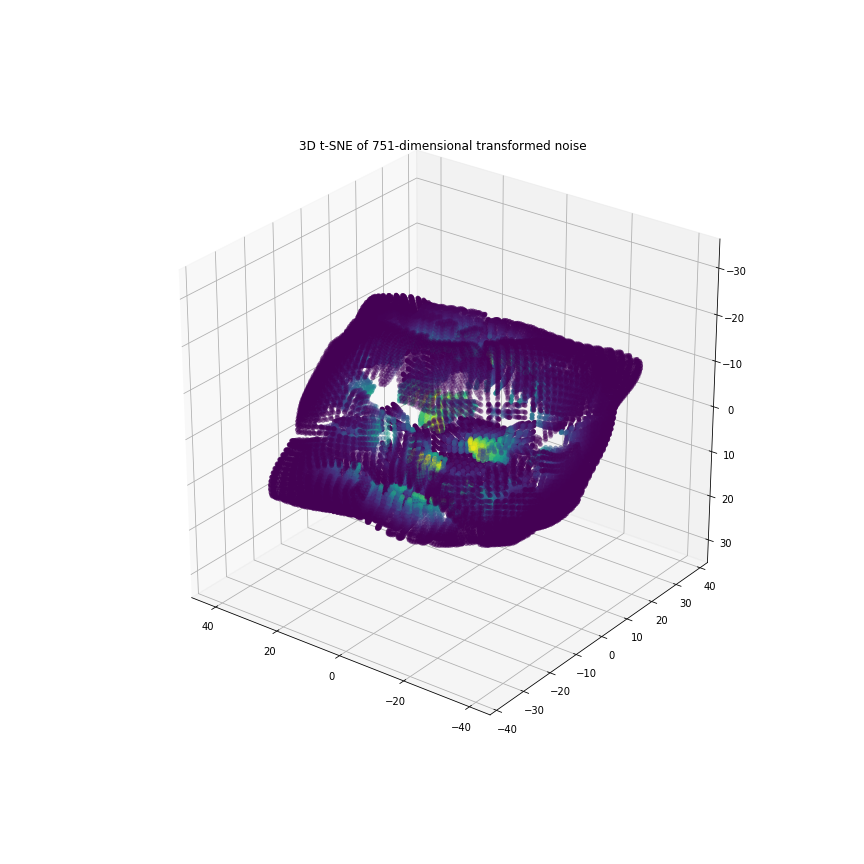

Text(0.5, 0.92, '3D t-SNE of 751-dimensional transformed noise')

In [44]:
%matplotlib notebook
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2], c=colors, linewidth=0.2)
plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
